In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# import mplcairo
# matplotlib.use("module://mplcairo.macosx")
# print(matplotlib.get_backend())

In [4]:
# !coman-python src/results.py udpos -q -mt ft --digest b30906d4 --sort_first

In [5]:
# with open("research/udpos/langs-ud.txt") as f:
#     ud_langs = {line.rstrip().split(" ", maxsplit=1)[0]: line.rstrip().split(" ", maxsplit=1)[1] for line in f}

ud_df = pd.read_csv("exports/udpos-langs.csv")
ud_langs = {row["language_id"]: row["language"] for _, row in ud_df.iterrows()}
ud_langs_scripts = {row["language"]: row["script"] for _, row in ud_df.iterrows()}

wiki_df = pd.read_csv("exports/wiki-langs.csv")
wiki_langs = {row["language_id"]: row["language"] for _, row in wiki_df.iterrows()}
# wiki_langs_scripts = {row["language"]: row["script"] for _, row in wiki_df.iterrows()}

with open("research/udpos/fams.txt") as f:
    lang_branches = {line.rstrip().split(" ", maxsplit=1)[0].replace("_", " "): line.rstrip().split(" ", maxsplit=1)[1] for line in f}

lang_fams = {lang: "Indo-European" if branch.startswith("IE") else branch for lang, branch in lang_branches.items()}

# with open("research/udpos/langs-xlmr.txt") as f:
#     model_langs = {line.rstrip().split(" ", maxsplit=1)[0]: line.rstrip().split(" ", maxsplit=1)[1] for line in f}

# with open("research/udpos/langs-xlmr-warn.txt") as f:
#     model_langs_warn = {line.rstrip().split(" ", maxsplit=1)[0]: line.rstrip().split(" ", maxsplit=1)[1] for line in f}

ldnd_df = pd.read_csv("research/udpos/ldnd.csv", index_col=0)
order_df = pd.read_csv("research/udpos/word-order.csv", index_col=1)

model_langs_warn = {}

ud_lang_names = set(ud_df.language.tolist())
model_lang_names = set(wiki_df.language.tolist())
model_lang_names_warn = set()

In [6]:
sum([lang_fams[l].startswith("IE") for l in ud_lang_names])

0

In [7]:
print(len(ud_lang_names), len(model_lang_names), len(ud_lang_names & model_lang_names), len(ud_lang_names - model_lang_names))

105 94 58 47


In [8]:
dfs = {}
for n_samples in [630, 1_250, 2_500, 5_000, 10_000, 20_000, 40_000, -1, -3]:
    if n_samples < 0:
        df = pd.read_csv(f"exports/udpos-ft-{-n_samples}epoch.csv")
    else:
        df = pd.read_csv(f"exports/udpos-ft-{n_samples:0>5}.csv")

    size_df = pd.read_csv("exports/udpos-sizes-train.csv", usecols=["language","size"], index_col="language")
    if n_samples < 0:
        df["full_train_size"] = df.lang_train.map(lambda x: size_df.loc[x, "size"])
        df["train_size"] = df["full_train_size"]
    else:
        df["full_train_size"] = df.lang_train.map(lambda x: size_df.loc[x, "size"])
        df["train_size"] = df.full_train_size.map(lambda x: min(x, n_samples))  # type: ignore
        
    df["num_samples"] = n_samples
    df["sampling"] = "none" if n_samples < 0 else df.train_size.map(lambda x: "undersampled" if x >= n_samples else "oversampled")
    df["sampling"] = df.sampling.astype("category")

    df["lang_train"] = df.lang_train.map(ud_langs.get)
    df["lang_pred"] = df.lang_pred.map(ud_langs.get)

    df["lang_train_family"] = df.lang_train.map(lang_fams.get)
    df["lang_pred_family"] = df.lang_pred.map(lang_fams.get)

    df["lang_train_pretrained"] = df.lang_train.map(lambda x: x in model_lang_names)
    df["lang_pred_pretrained"] = df.lang_pred.map(lambda x: x in model_lang_names)

    df["lang_train_script"] = df.lang_train.map(ud_langs_scripts.get)
    df["lang_pred_script"] = df.lang_pred.map(ud_langs_scripts.get)

    def get_ldnd(x):
        try:
            return ldnd_df.loc[x.lang_train, x.lang_pred]
        except KeyError:
            return 100
    df["ldnd"] = df.apply(get_ldnd, axis=1)

    def get_sov(x):
        try:
            return order_df.loc[x.lang_train, x.lang_pred].SOV
        except KeyError:
            return np.nan
    
    # ["language", "SOV", "SV", "OV", "OOV", "AdpNP", "GN", "AN", "DN", "NN", "RN", "QP"]
    df["sov_order_train"] = df.lang_train.map(lambda x: order_df.SOV.get(x))
    df["sov_order_pred"] = df.lang_pred.map(lambda x: order_df.SOV.get(x))
    df["sv_order_train"] = df.lang_train.map(lambda x: order_df.SV.get(x))
    df["sv_order_pred"] = df.lang_pred.map(lambda x: order_df.SV.get(x))
    df["ov_order_train"] = df.lang_train.map(lambda x: order_df.OV.get(x))
    df["ov_order_pred"] = df.lang_pred.map(lambda x: order_df.OV.get(x))
    df["adpnp_order_train"] = df.lang_train.map(lambda x: order_df.AdpNP.get(x))
    df["adpnp_order_pred"] = df.lang_pred.map(lambda x: order_df.AdpNP.get(x))
    df["gn_order_train"] = df.lang_train.map(lambda x: order_df.GN.get(x))
    df["gn_order_pred"] = df.lang_pred.map(lambda x: order_df.GN.get(x))
    df["an_order_train"] = df.lang_train.map(lambda x: order_df.AN.get(x))
    df["an_order_pred"] = df.lang_pred.map(lambda x: order_df.AN.get(x))
    df["dn_order_train"] = df.lang_train.map(lambda x: order_df.DN.get(x))
    df["dn_order_pred"] = df.lang_pred.map(lambda x: order_df.DN.get(x))
    df["nn_order_train"] = df.lang_train.map(lambda x: order_df.NN.get(x))
    df["nn_order_pred"] = df.lang_pred.map(lambda x: order_df.NN.get(x))
    df["rn_order_train"] = df.lang_train.map(lambda x: order_df.RN.get(x))
    df["rn_order_pred"] = df.lang_pred.map(lambda x: order_df.RN.get(x))
    df["qp_order_train"] = df.lang_train.map(lambda x: order_df.QP.get(x))
    df["qp_order_pred"] = df.lang_pred.map(lambda x: order_df.QP.get(x))

    dfs[n_samples] = df

df = dfs[10_000]
df

,Unnamed: 0,task_type,task_name,digest,lang_train,lang_pred,model_id,model_type,score,full_train_size,...,an_order_train,an_order_pred,dn_order_train,dn_order_pred,nn_order_train,nn_order_pred,rn_order_train,rn_order_pred,qp_order_train,qp_order_pred
0,0,token-classification,udpos28,1d6ca3e8,English,English,xlm-roberta-base,ft,96.045875,19912,...,Adjective-Noun,Adjective-Noun,Demonstrative-Noun,Demonstrative-Noun,Numeral-Noun,Numeral-Noun,Noun-Relative clause,Noun-Relative clause,No question particle,No question particle
1,1,token-classification,udpos28,1d6ca3e8,English,Dutch,xlm-roberta-base,ft,90.391066,19912,...,Adjective-Noun,Adjective-Noun,Demonstrative-Noun,Demonstrative-Noun,Numeral-Noun,Numeral-Noun,Noun-Relative clause,Noun-Relative clause,No question particle,No question particle
2,2,token-classification,udpos28,1d6ca3e8,English,German,xlm-roberta-base,ft,88.613954,19912,...,Adjective-Noun,Adjective-Noun,Demonstrative-Noun,Demonstrative-Noun,Numeral-Noun,Numeral-Noun,Noun-Relative clause,Noun-Relative clause,No question particle,No question particle
3,3,token-classification,udpos28,1d6ca3e8,English,Italian,xlm-roberta-base,ft,87.774192,19912,...,Adjective-Noun,Noun-Adjective,Demonstrative-Noun,Demonstrative-Noun,Numeral-Noun,Numeral-Noun,Noun-Relative clause,Noun-Relative clause,No question particle,No question particle
4,4,token-classification,udpos28,1d6ca3e8,English,French,xlm-roberta-base,ft,87.440783,19912,...,Adjective-Noun,Noun-Adjective,Demonstrative-Noun,Demonstrative-Noun,Numeral-Noun,Numeral-Noun,Noun-Relative clause,Noun-Relative clause,No question particle,Initial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,6820,token-classification,udpos28,1d6ca3e8,Uyghur,Scottish Gaelic,xlm-roberta-base,ft,48.034398,1543,...,Adjective-Noun,Noun-Adjective,Unknown,Noun-Demonstrative,Unknown,Numeral-Noun,Relative clause-Noun,Noun-Relative clause,Unknown,No question particle
6821,6821,token-classification,udpos28,1d6ca3e8,Uyghur,Khunsari,xlm-roberta-base,ft,52.702703,1543,...,Adjective-Noun,None,Unknown,None,Unknown,None,Relative clause-Noun,None,Unknown,None
6822,6822,token-classification,udpos28,1d6ca3e8,Uyghur,Hebrew,xlm-roberta-base,ft,77.083333,1543,...,Adjective-Noun,Noun-Adjective,Unknown,Noun-Demonstrative,Unknown,Numeral-Noun,Relative clause-Noun,Noun-Relative clause,Unknown,Initial
6823,6823,token-classification,udpos28,1d6ca3e8,Uyghur,Uyghur,xlm-roberta-base,ft,89.921923,1543,...,Adjective-Noun,Adjective-Noun,Unknown,Unknown,Unknown,Unknown,Relative clause-Noun,Relative clause-Noun,Unknown,Unknown


## Average scores per effective training size

In [9]:
df.full_train_size.min(), df.full_train_size.max()

(127, 163106)

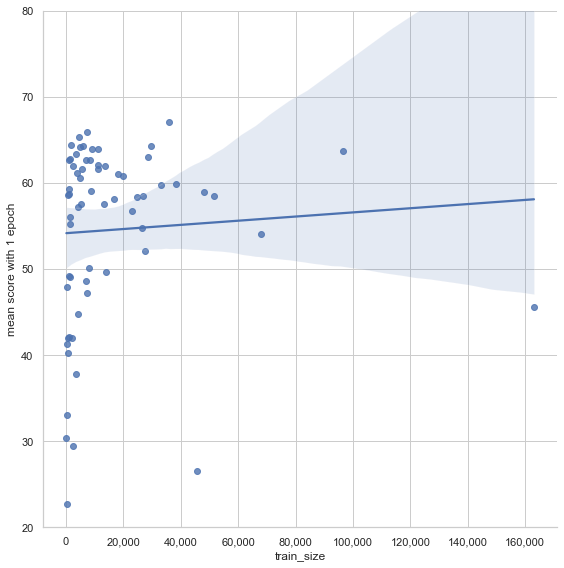

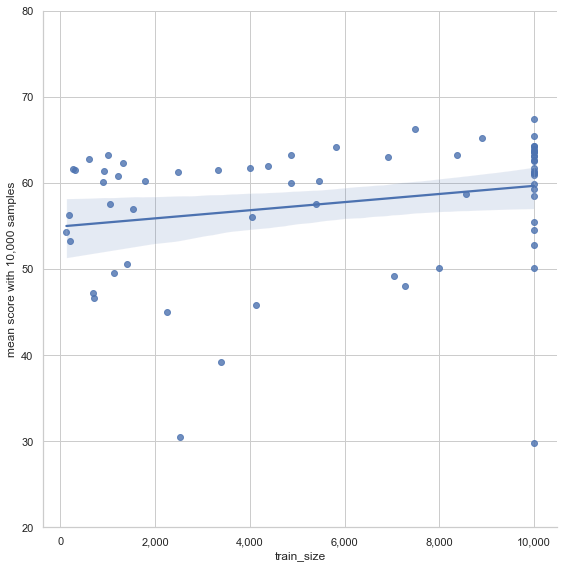

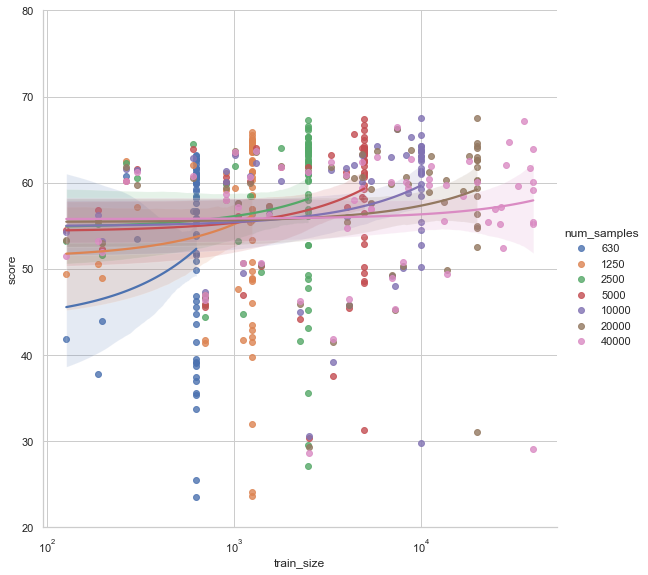

In [10]:
global_df = pd.concat([df for n, df in dfs.items() if n > 0])

size_score_df = dfs[-1].groupby("lang_train").mean()
fig = sns.lmplot(x="train_size", y="score", data=size_score_df, height=8)
fig.set(ylim=(20,80))
fig.ax.set_ylabel("mean score with 1 epoch")
fig.ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# fig.ax.set_xscale("log")


size_score_df = df.groupby("lang_train").mean()
fig = sns.lmplot(x="train_size", y="score", data=size_score_df, height=8)
fig.set(ylim=(20,80))
fig.ax.set_ylabel(f"mean score with {int(size_score_df['num_samples'].mean()):,} samples")
fig.ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# # fig.ax.set_xscale("log")

size_score_df = global_df.groupby(["lang_train", "num_samples"]).mean().reset_index()
fig = sns.lmplot(x="train_size", y="score", hue="num_samples", data=size_score_df, height=8)
fig.set(ylim=(20,80))
fig.ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
fig.ax.set_xscale("log")

num_samples
1\nepoch     54.544281
1,250        55.646304
10,000       57.733166
2,500        57.497464
20,000       57.129447
3\nepochs    55.362327
40,000       56.442510
5,000        57.949858
630          51.881960
Name: score, dtype: float64


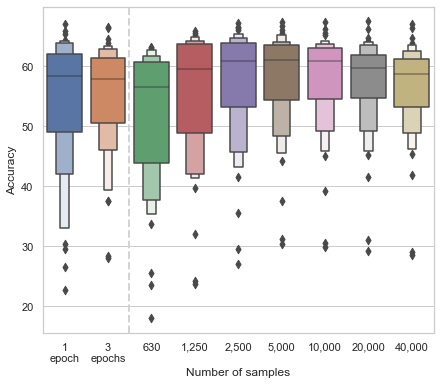

In [11]:
size_score_df = pd.concat(dfs.values()).groupby(["lang_train", "num_samples"]).mean().reset_index()
size_score_df.sort_values("num_samples", key=lambda x: x.map(lambda y: -y/10 if y < 0 else y), inplace=True)
size_score_df["num_samples"] = size_score_df.num_samples.map(lambda x: f"{x:,}" if x > 0 else f"{-x}\nepoch{'s' if x < -1 else ''}")

print(size_score_df.groupby("num_samples")["score"].mean())

plt.figure(figsize=(7,6))
ax = sns.boxenplot(x="num_samples", y="score", data=size_score_df)
ax.set_xlabel("Number of samples")
ax.set_ylabel("Accuracy")
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.axvline(1.491, c="lightgray", ls="--", lw=2)
plt.savefig("plots/boxes-sample-size.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

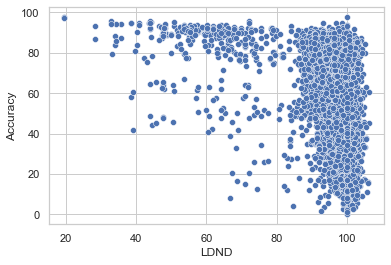

In [54]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="ldnd", y="score", markers=".", data=df)
plt.xlabel("LDND")
plt.ylabel("Accuracy")
plt.savefig("plots/ldnd.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

In [13]:
for lang in ["German", "Czech", "Russian", "Turkish"]:
    for n, df_ in dfs.items():
        print(n, df_.loc[df_.lang_train == lang].score.mean())
    print()

630 60.90945412202096
1250 64.43702465026944
2500 62.351372158615234
5000 59.76435179479602
10000 59.306777105193376
20000 54.9302750786745
40000 55.14424755460962
-1 45.5831905745356
-3 47.6117609700518

630 61.2782570388214
1250 62.64492649164947
2500 63.519725822332546
5000 63.93363942365913
10000 63.65917711509487
20000 64.64913021362845
40000 63.856674682148174
-1 63.750501286268836
-3 61.32469988209759

630 60.48794167617488
1250 64.16975685125887
2500 63.890998268728424
5000 63.85865879978409
10000 63.148645072802616
20000 58.48463105621697
40000 55.389442130937034
-1 54.05136327349235
-3 51.919651286862354

630 49.8037664828851
1250 56.38682055335924
2500 58.73580746726815
5000 59.214102845785206
10000 59.85910316679503
20000 59.353163944771595
40000 59.155302755256315
-1 58.43883564693678
-3 57.57006663790248



## Effects of oversampling / undersampling

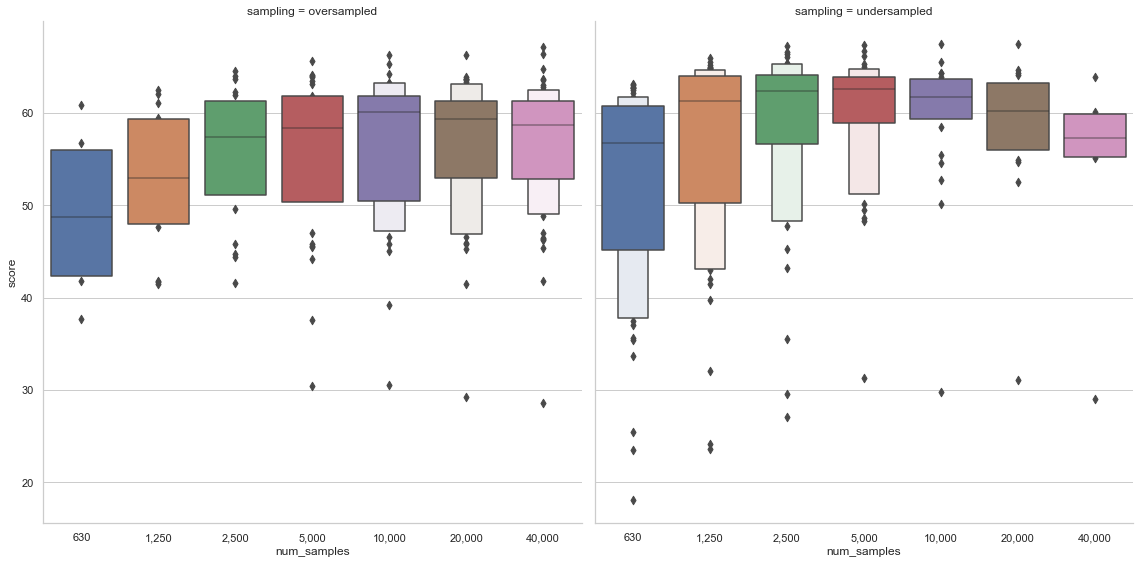

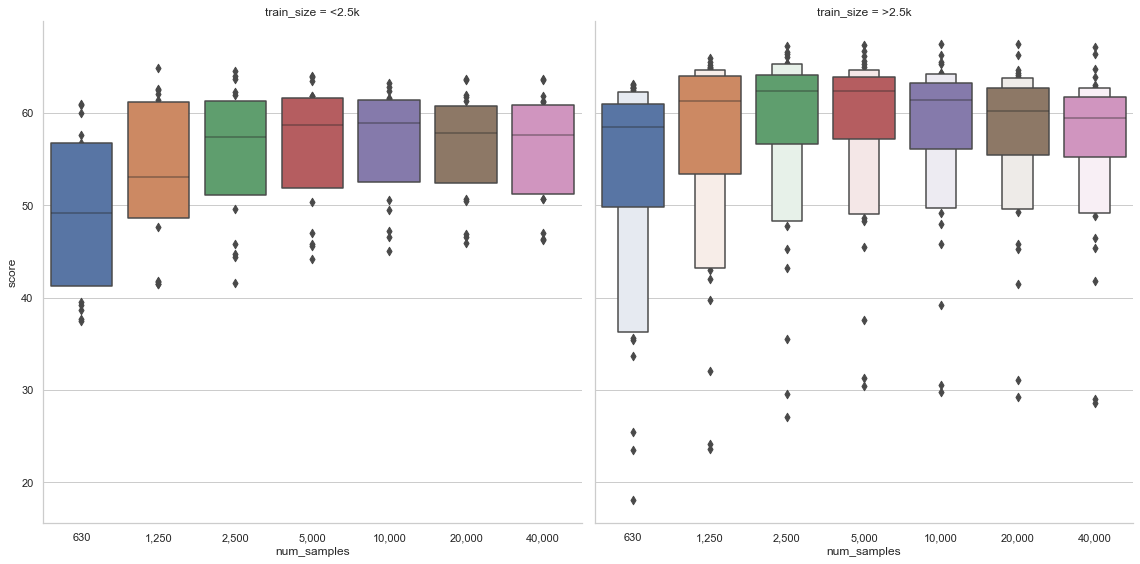

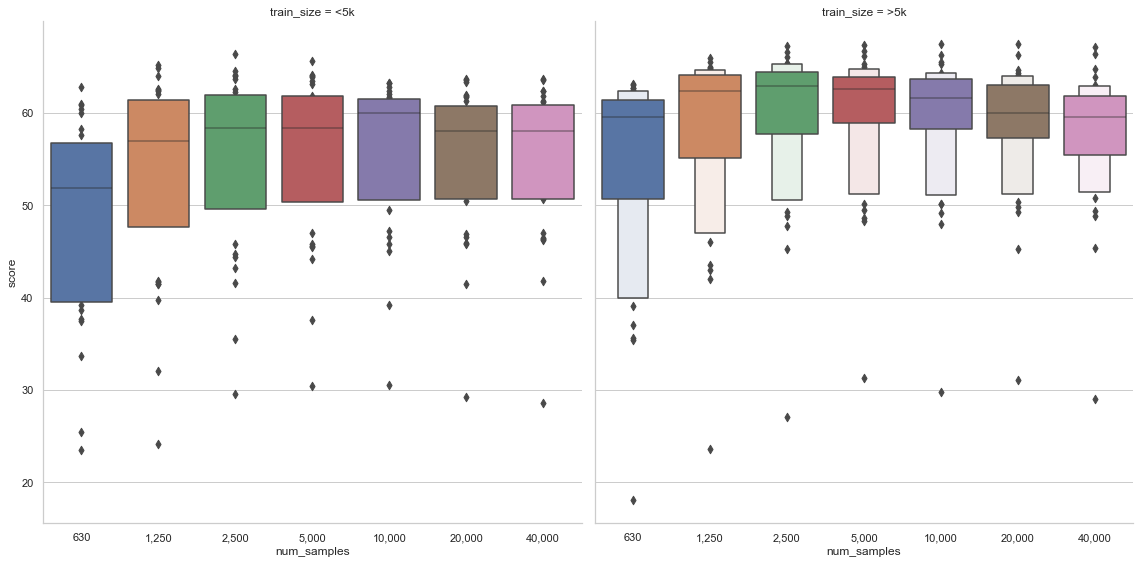

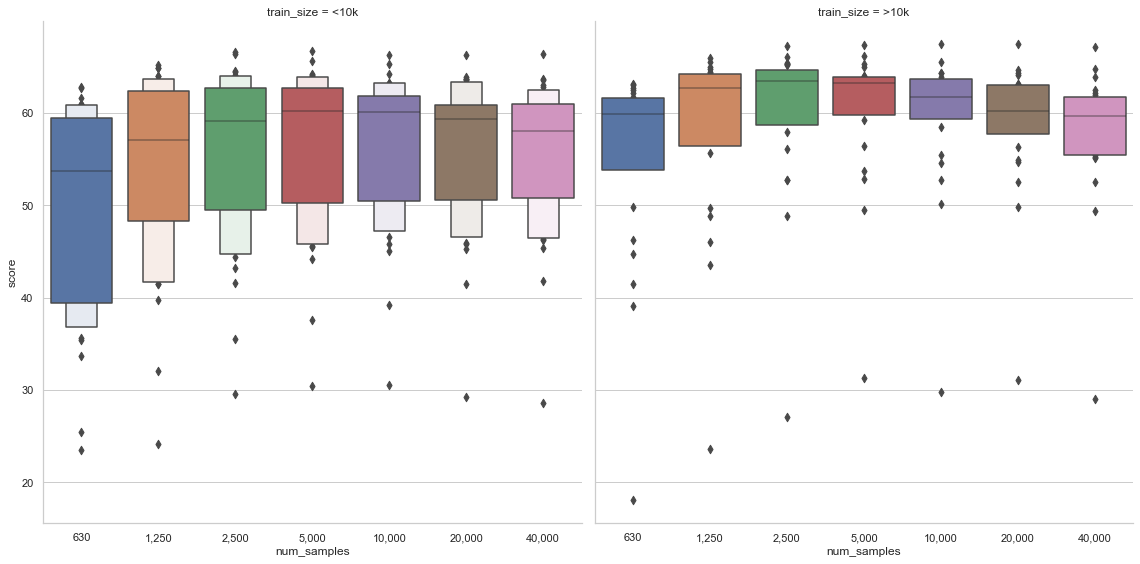

In [14]:
df_ = pd.concat([v for n, v in dfs.items() if n > 0])

size_score_df = df_.groupby(["lang_train", "num_samples", "sampling"]).mean().reset_index()
size_score_df["num_samples"] = size_score_df.num_samples.map(lambda x: f"{x:,}" if x > 0 else f"{-x} epoch")
ax = sns.catplot(x="num_samples", y="score", col="sampling", kind="boxen", data=size_score_df, height=8)

size_score_df = df_.groupby(["lang_train", "num_samples", "full_train_size"]).mean().reset_index()
size_score_df["num_samples"] = size_score_df.num_samples.map(lambda x: f"{x:,}" if x > 0 else f"{-x} epoch")

size_score_df["train_size"] = size_score_df.full_train_size.map(lambda x: ">2.5k" if x >= 2_500 else "<2.5k")
ax = sns.catplot(x="num_samples", y="score", col="train_size", kind="boxen", data=size_score_df, height=8)

size_score_df["train_size"] = size_score_df.full_train_size.map(lambda x: ">5k" if x >= 5_000 else "<5k")
ax = sns.catplot(x="num_samples", y="score", col="train_size", kind="boxen", data=size_score_df, height=8)

size_score_df["train_size"] = size_score_df.full_train_size.map(lambda x: ">10k" if x >= 10_000 else "<10k")
ax = sns.catplot(x="num_samples", y="score", col="train_size", kind="boxen", data=size_score_df, height=8)

## Performance on source language

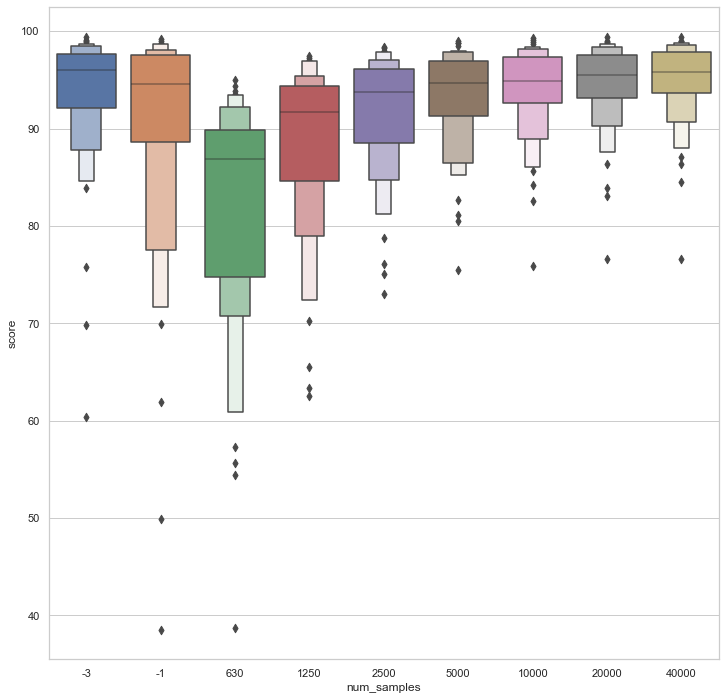

In [15]:
df_ = pd.concat(dfs.values())
df_ = df_.loc[df.lang_train == df.lang_pred]
plt.figure(figsize=(12,12))
ax = sns.boxenplot(x="num_samples", y="score", data=df_)

## Performance for every source - target pair

In [16]:
table = df.pivot(index='lang_pred', columns='lang_train', values='score')
# train_langs = table.columns.tolist()
# table.index = table.index.map(lambda x: x if x in table.columns else f"{x} 🛑")
masked_table = table.mask(table.apply(lambda x: x.name == x.index))
table

lang_train,Afrikaans,Ancient Greek,Arabic,Armenian,Basque,Belarusian,Bulgarian,Catalan,Chinese,Classical Chinese,...,Tamil,Telugu,Turkish,Ukrainian,Urdu,Uyghur,Vietnamese,Welsh,Western Armenian,Wolof
lang_pred,,,,,,,,,,,,,,,,,,,,,
Afrikaans,98.926761,58.372255,62.476399,83.921296,61.164663,76.657061,81.526384,86.028023,58.551128,31.779787,...,66.510981,64.275067,71.270993,81.665507,73.964027,61.780781,53.801053,74.659644,81.675445,48.971480
Akkadian,28.608762,38.862414,3.935434,7.040738,40.937740,8.178324,40.507302,40.983859,16.310530,25.857033,...,28.439662,37.448117,39.754035,17.524981,19.508071,37.033051,34.035357,42.398155,29.331284,41.644889
Akuntsu,24.421594,30.848329,10.539846,11.568123,41.131105,11.053985,39.588689,43.444730,16.452442,19.280206,...,19.280206,43.187661,49.100257,15.167095,15.424165,47.557841,43.444730,35.989717,21.336761,35.732648
Albanian,79.392625,63.340564,68.112798,75.813449,66.919740,76.247289,78.416486,79.175705,59.002169,31.561822,...,60.954447,60.303688,71.475054,79.718004,71.800434,63.449024,57.049892,76.789588,83.514100,51.843818
Ancient Greek,59.347008,89.563213,41.113996,67.385405,59.215709,66.886470,61.926298,61.993406,65.182505,31.879322,...,52.933796,48.049485,58.535874,62.962098,56.262948,51.676247,44.921658,55.437225,68.383275,39.267062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Warlpiri,39.676113,49.392713,18.623482,25.506073,43.319838,20.647773,40.080972,36.437247,29.554656,14.979757,...,32.388664,48.987854,48.582996,32.388664,19.838057,55.465587,48.987854,36.842105,38.461538,42.510121
Welsh,70.313994,57.897673,58.774307,65.341090,53.546382,64.193497,66.687918,65.970673,52.319095,27.279248,...,54.191903,54.462863,62.942302,66.815429,63.699394,57.124641,50.948358,94.931463,63.802996,41.504622
Western Armenian,79.994967,67.148968,58.530448,84.474082,77.403120,78.397081,83.228485,78.699044,67.211877,34.776044,...,70.797685,66.041772,70.457977,79.793659,74.081530,71.766482,58.152994,68.683946,93.948163,62.858581


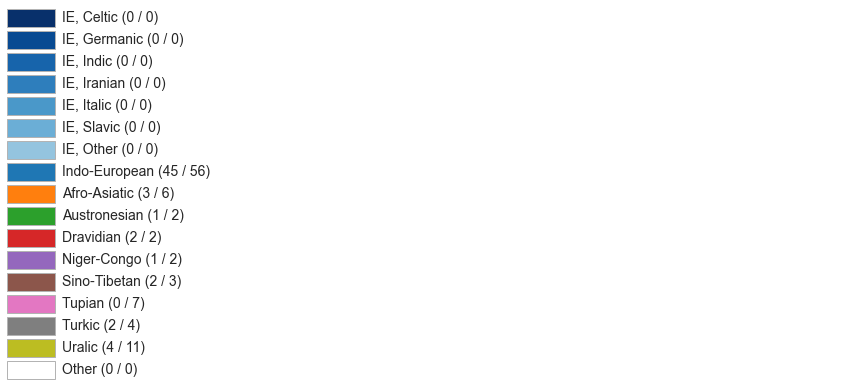

In [17]:


import matplotlib as mpl
iecolors = mpl.cm.get_cmap("Blues", 11)
tab10 = mpl.cm.get_cmap("tab10")

fam_colors = {
 'IE, Celtic': iecolors(10),
 'IE, Germanic': iecolors(9),
 'IE, Indic': iecolors(8),
 'IE, Iranian': iecolors(7),
 'IE, Italic': iecolors(6),
 'IE, Slavic': iecolors(5),
 'IE, Other': iecolors(4),
 'Indo-European': tab10(0),
 'Afro-Asiatic': tab10(1),
 'Austronesian': tab10(2),
 'Dravidian': tab10(3),
 'Niger-Congo': tab10(4),
 'Sino-Tibetan': tab10(5),
 'Tupian': tab10(6),
 'Turkic': tab10(7),
 'Uralic': tab10(8),
 'Other': (1,1,1,1),
}


from matplotlib.patches import Rectangle


def plot_colortable(colors, pred_counts, train_counts):
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    names = list(colors)

    n = len(names)
    ncols = 1
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, f"{name} ({train_counts.get(name, '0')} / {pred_counts.get(name, '0')})", fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

pred_fam_counts = dict(df[["lang_pred", "lang_pred_family"]].drop_duplicates().lang_pred_family.value_counts())
train_fam_counts = dict(df[["lang_train", "lang_train_family"]].drop_duplicates().lang_train_family.value_counts())
plot_colortable(fam_colors, pred_fam_counts, train_fam_counts)

# sorted(row_families.unique())

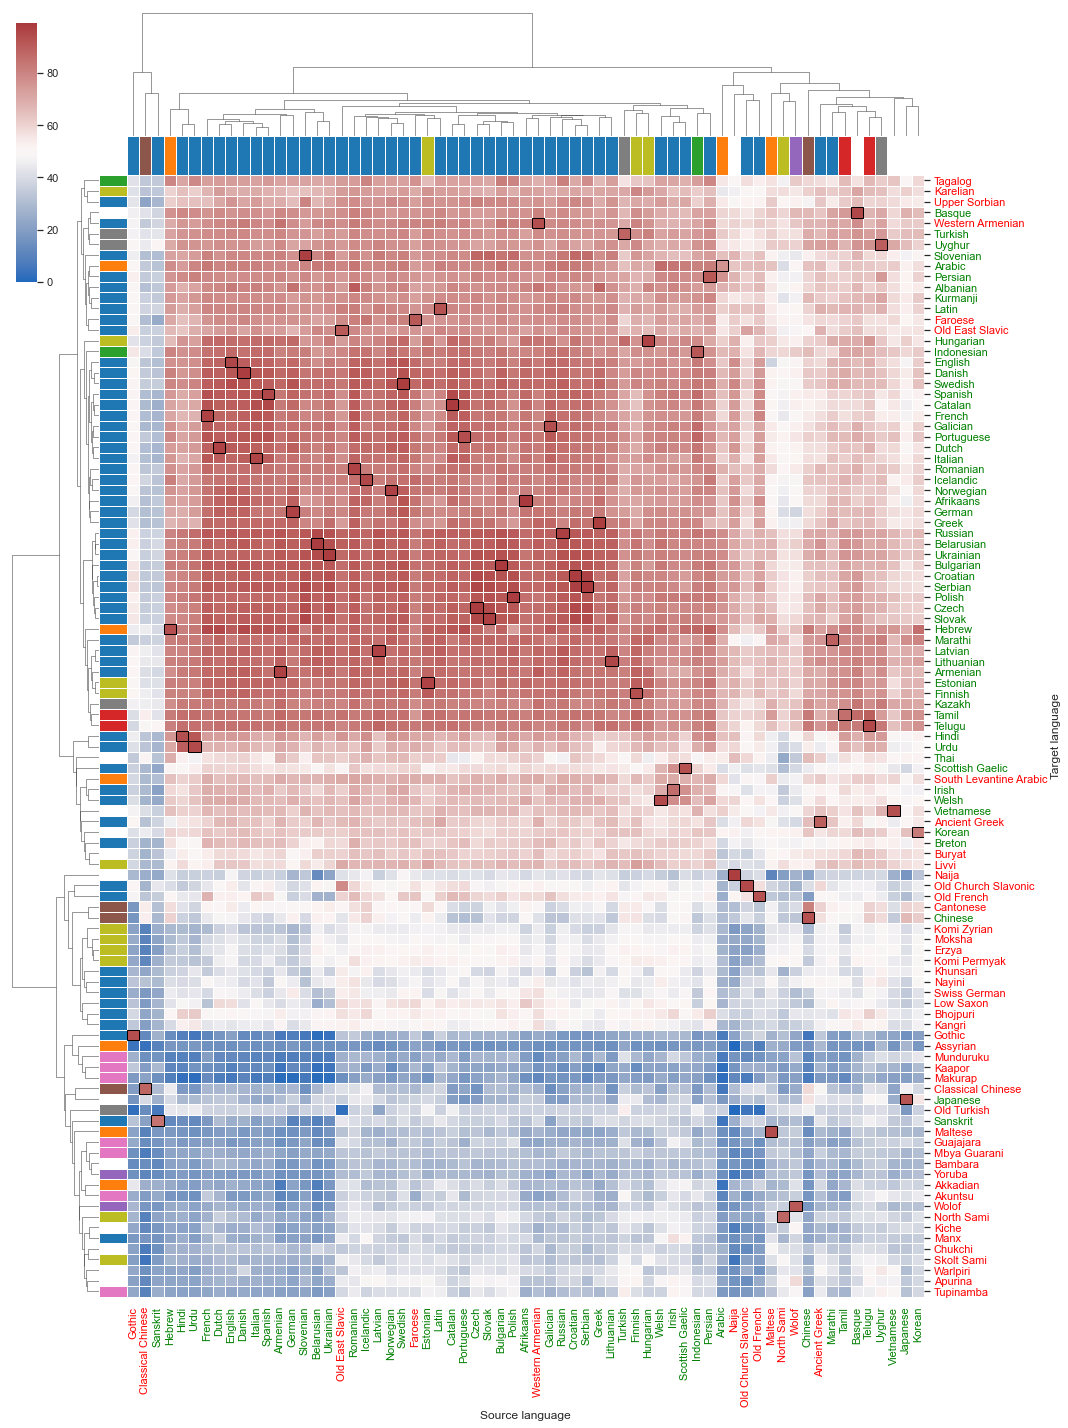

In [44]:
from matplotlib.patches import Rectangle

def create_clustermap(table, *, figsize=(10,10), metric="euclidean", map_families=True, color_families=True, color_ticks=True):
    row_families = table.index.map(lang_fams if map_families is True else map_families) if map_families else table.index.map(lambda x: x.split(" (")[0])
    col_families = table.columns.map(lang_fams if map_families is True else map_families) if map_families else table.columns.map(lambda x: x.split(" (")[0])

    if color_families is False:
        row_colors, col_colors = None, None
    else:
        color_families = fam_colors if color_families is True else color_families
        row_colors = row_families.map(lambda x: color_families.get(x, color_families["Other"]))
        col_colors = col_families.map(lambda x: color_families.get(x, color_families["Other"]))

    g = sns.clustermap(
        table,
        center=50,
        cmap="vlag",
        metric=metric,
        method="average",
        dendrogram_ratio=(.1, .1),
        cbar_pos=(0.02, 0.8, 0.02, 0.18),
        linewidths=.5,
        figsize=figsize,
        xticklabels=True,
        yticklabels=True,
        row_colors=row_colors,
        col_colors=col_colors,
    )

    ax = g.ax_heatmap

    # Add source==target outlines
    assert g.dendrogram_row
    assert g.dendrogram_col
    row_names = list(map(lambda i: table.index[i].split("(")[0].strip(), g.dendrogram_row.reordered_ind))
    col_names = list(map(lambda i: table.columns[i].split("(")[0].strip(), g.dendrogram_col.reordered_ind))
    for i, row_name in enumerate(row_names):
        if row_name in col_names:
            j = col_names.index(row_name)
            ax.add_patch(Rectangle((j,i), 1, 1, fill=False, edgecolor="black", lw=1))
    
    if color_ticks:
        # Add tick colors
        green_names = model_lang_names if color_ticks is True else color_ticks
        [t.set_color("orange" if t.get_text() in model_langs_warn else "green" if t.get_text().split("(")[0].strip() in green_names else "red") for t in ax.xaxis.get_ticklabels()]
        [t.set_color("orange" if t.get_text() in model_langs_warn else "green" if t.get_text().split("(")[0].strip() in green_names else "red") for t in ax.yaxis.get_ticklabels()]
    return ax


ax = create_clustermap(table, figsize=(15, 20))
ax.set_xlabel("Source language")
ax.set_ylabel("Target language")

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/heatmap.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

## Average score per source language

In [19]:
df.set_index("lang_train").lang_train_pretrained.loc["English"][0]

True

  1   1.5 Classical Chinese              * 29.2
  2   3.1 Sanskrit                         30.0
  3   4.6 Gothic                         * 38.7
  4   6.2 North Sami                     * 44.6
  5   7.7 Old Church Slavonic            * 45.3
  6   9.2 Arabic                           46.3
  7  10.8 Wolof                          * 46.8
  8  12.3 Naija                          * 47.5
  9  13.8 Japanese                         48.7
 10  15.4 Maltese                        * 49.1
 11  16.9 Chinese                          49.7
 12  18.5 Old French                     * 49.7
 13  20.0 Vietnamese                       50.2
 14  21.5 Korean                           52.5
 15  23.1 Marathi                          52.9
 16  24.6 Tamil                            54.0
 17  26.2 Ancient Greek                  * 54.2
 18  27.7 Hindi                            55.1
 19  29.2 Urdu                             55.7
 20  30.8 Hebrew                           55.9
 21  32.3 Uyghur                        

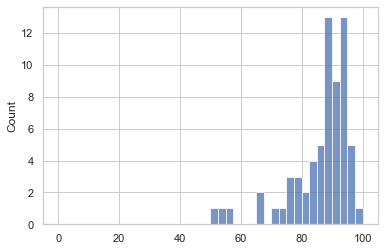

In [62]:

sns.histplot(masked_table.max(axis=0), bins=40, binrange=(0,100))
lang_train_pretrained = df.set_index("lang_train").lang_train_pretrained

y0 = 50
for i, (x,y) in enumerate(masked_table.mean(axis=0).sort_values().iteritems(), start=1):
    print(f"{i:>3} {i/65*100:>5.1f} {x:<30} {' ' if lang_train_pretrained.loc[x][0] else '*'} {y:.1f}")
    y0 = y

In [21]:
pd.set_option('display.max_rows', None)
table.loc[:, "Arabic"].sort_values()

lang_pred
Makurap                    2.054795
Kaapor                     2.500000
Akkadian                   3.935434
Sanskrit                   4.904659
Classical Chinese          5.638132
Munduruku                  6.976744
Gothic                     7.246519
Akuntsu                   10.539846
Wolof                     14.560380
Assyrian                  14.569536
Yoruba                    14.902292
Guajajara                 15.011038
Maltese                   15.117854
Bambara                   15.749114
Japanese                  17.854606
Manx                      18.251214
Tupinamba                 18.345324
Warlpiri                  18.623482
Kiche                     19.000337
North Sami                19.240759
Mbya Guarani              20.257967
Apurina                   22.385621
Old French                25.550179
Skolt Sami                25.910558
Moksha                    26.204927
Naija                     26.604865
Nayini                    26.923077
Erzya             

In [22]:
unmasked_table = table.mask(table.apply(lambda x: x.name != x.index))

np.nanmean(masked_table), np.nanstd(masked_table)

(57.383750436431335, 22.414443830612644)

## Average score per target language

<AxesSubplot:ylabel='Count'>

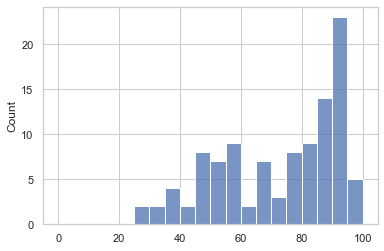

In [23]:
sns.histplot(masked_table.max(axis=1), bins=20, binrange=(0,100))

## Heatmaps per max target performance

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

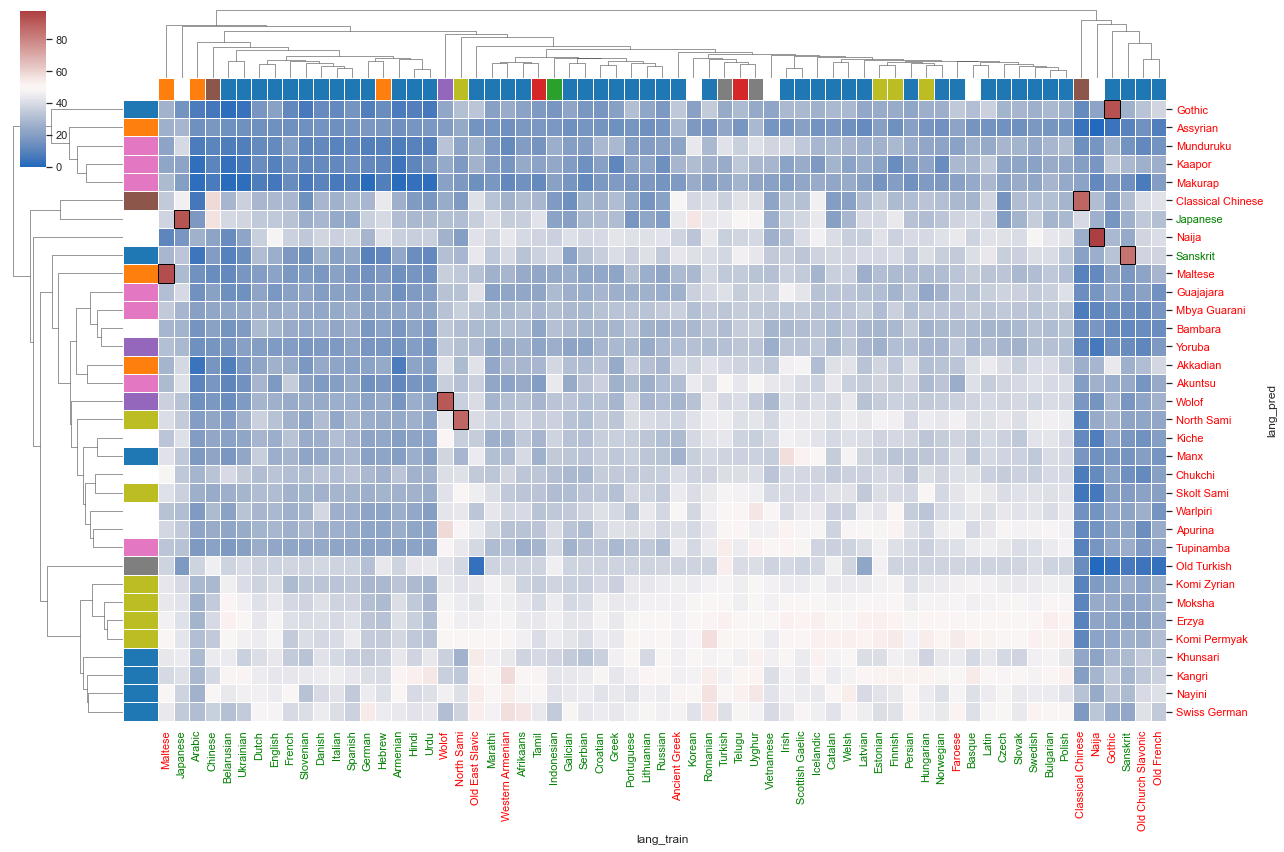

In [24]:
masked_table = table.mask(table.apply(lambda x: x.name == x.index))
create_clustermap(table.loc[masked_table.max(axis=1) < 60], figsize=(18,12))

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

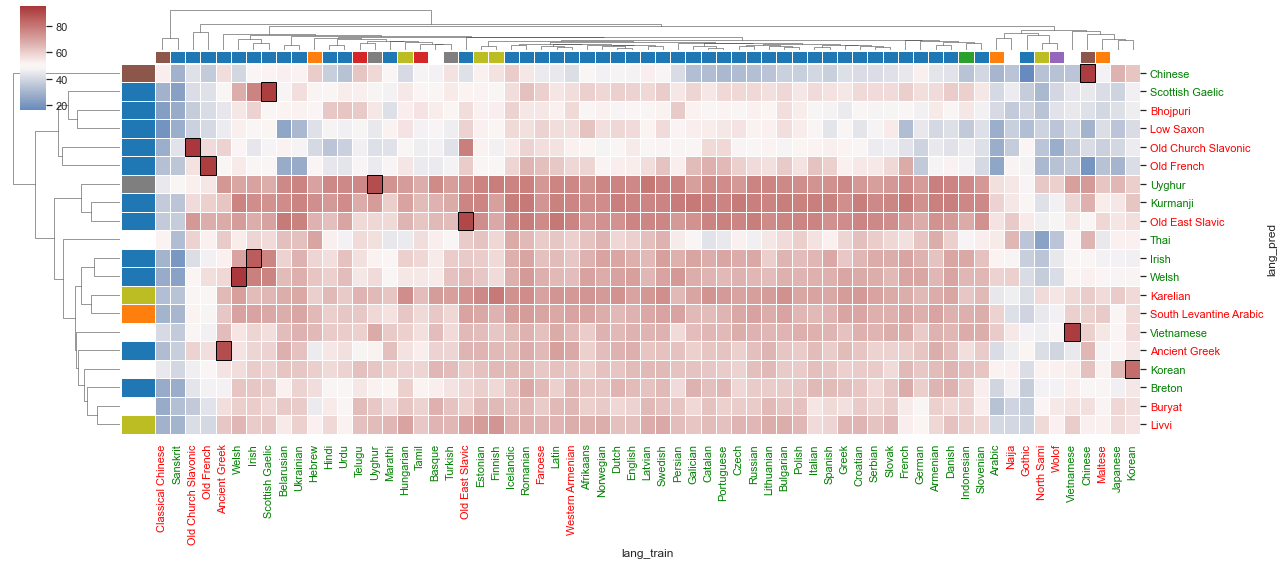

In [25]:
create_clustermap(table.loc[(masked_table.max(axis=1) >= 60) & (masked_table.max(axis=1) < 80)], figsize=(18,8))

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

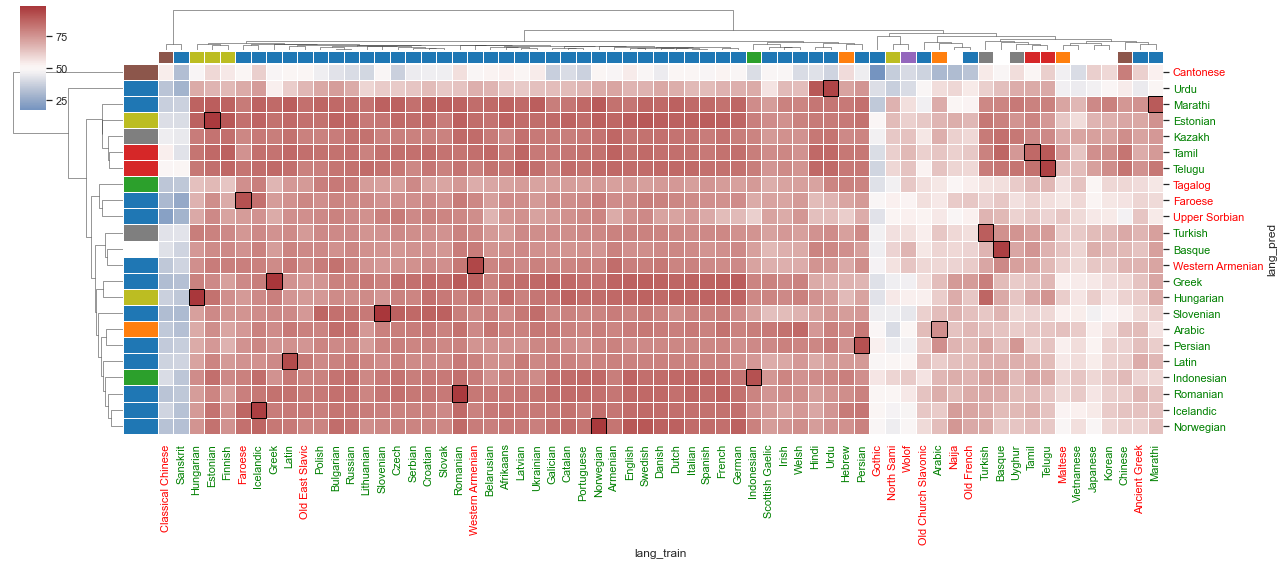

In [26]:
create_clustermap(table.loc[(masked_table.max(axis=1) >= 80) & (masked_table.max(axis=1) < 90)], figsize=(18,8))

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

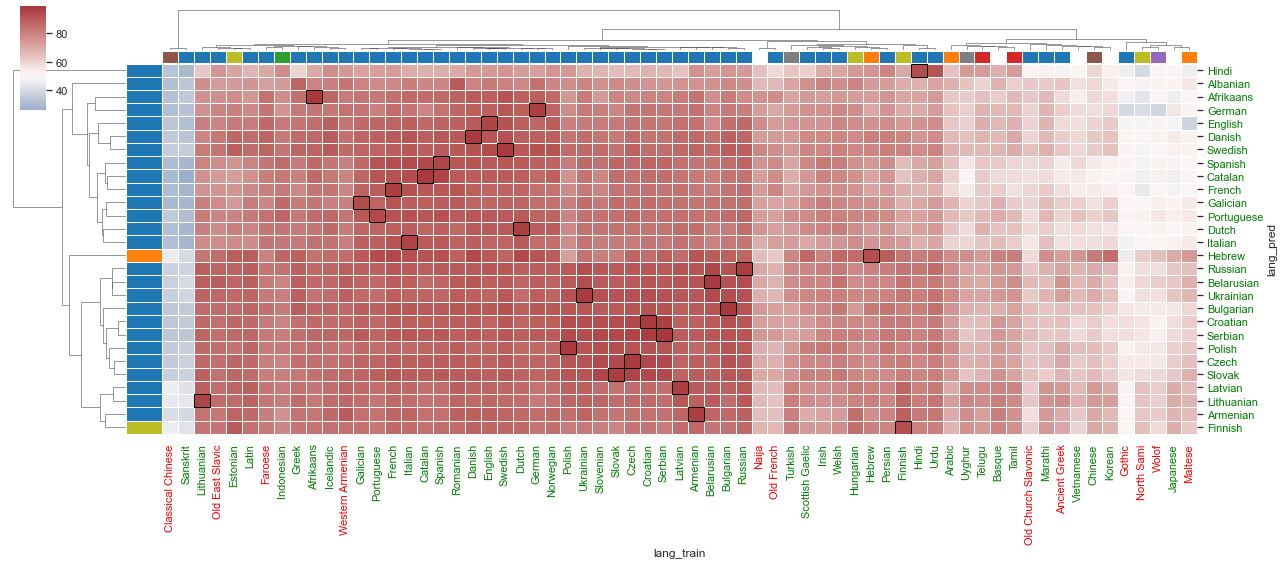

In [27]:
create_clustermap(table.loc[masked_table.max(axis=1) >= 90], figsize=(18,8))
# create_clustermap(table.loc[masked_table.max(axis=1) >= 90], figsize=(18,8), metric="cosine")

## Heatmaps per max source performance

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

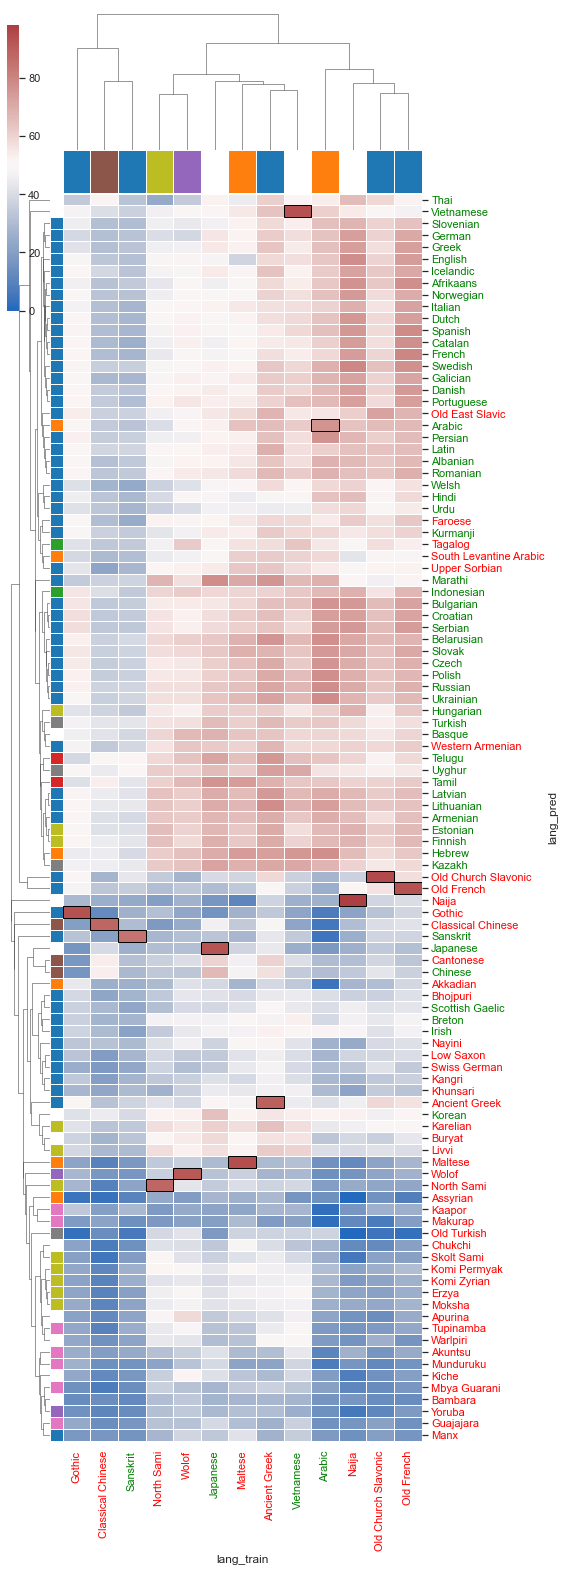

In [28]:
create_clustermap(table.loc[:,masked_table.max(axis=0) < 80], figsize=(8,22))

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

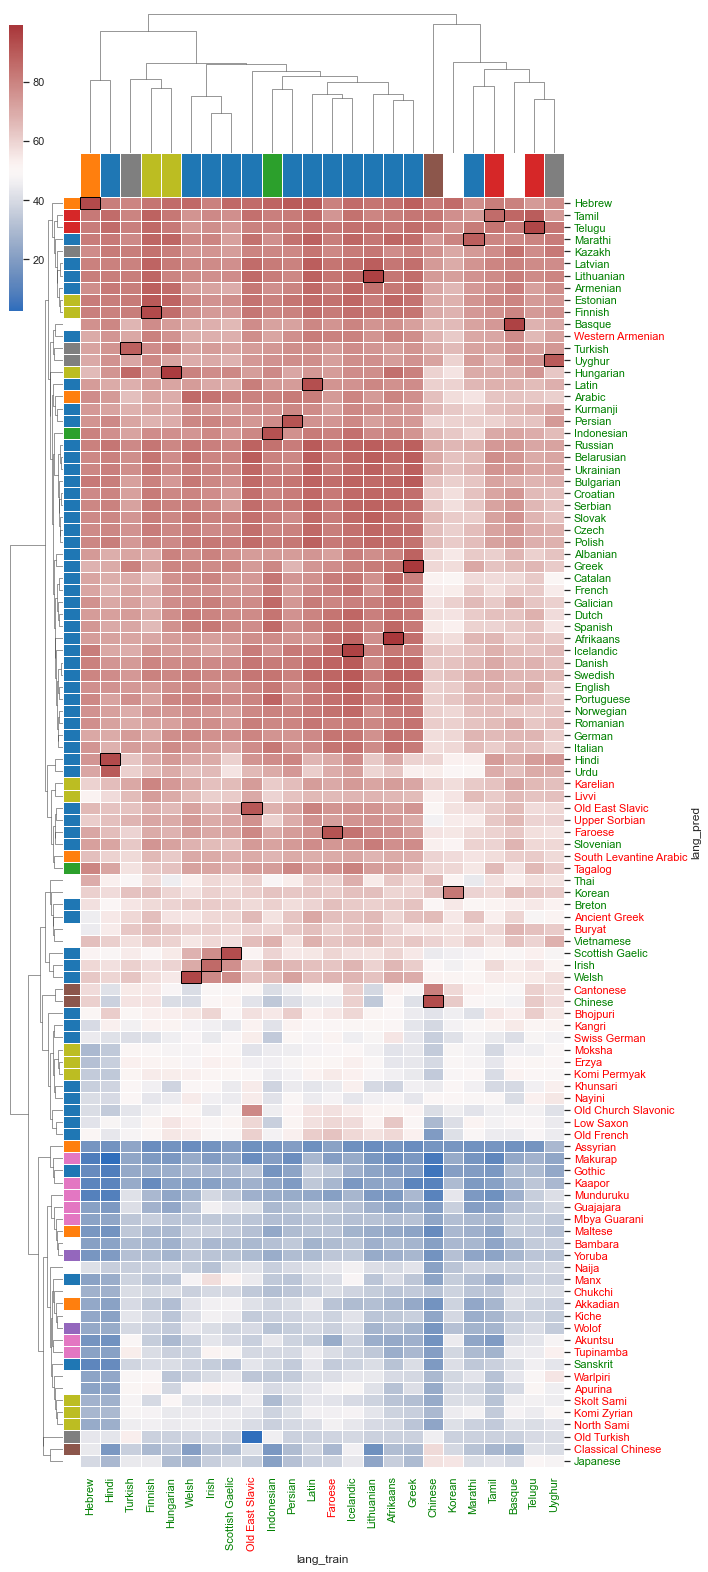

In [29]:
create_clustermap(table.loc[:,(masked_table.max(axis=0) >= 80) & (masked_table.max(axis=0) < 90)], figsize=(10,22))

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

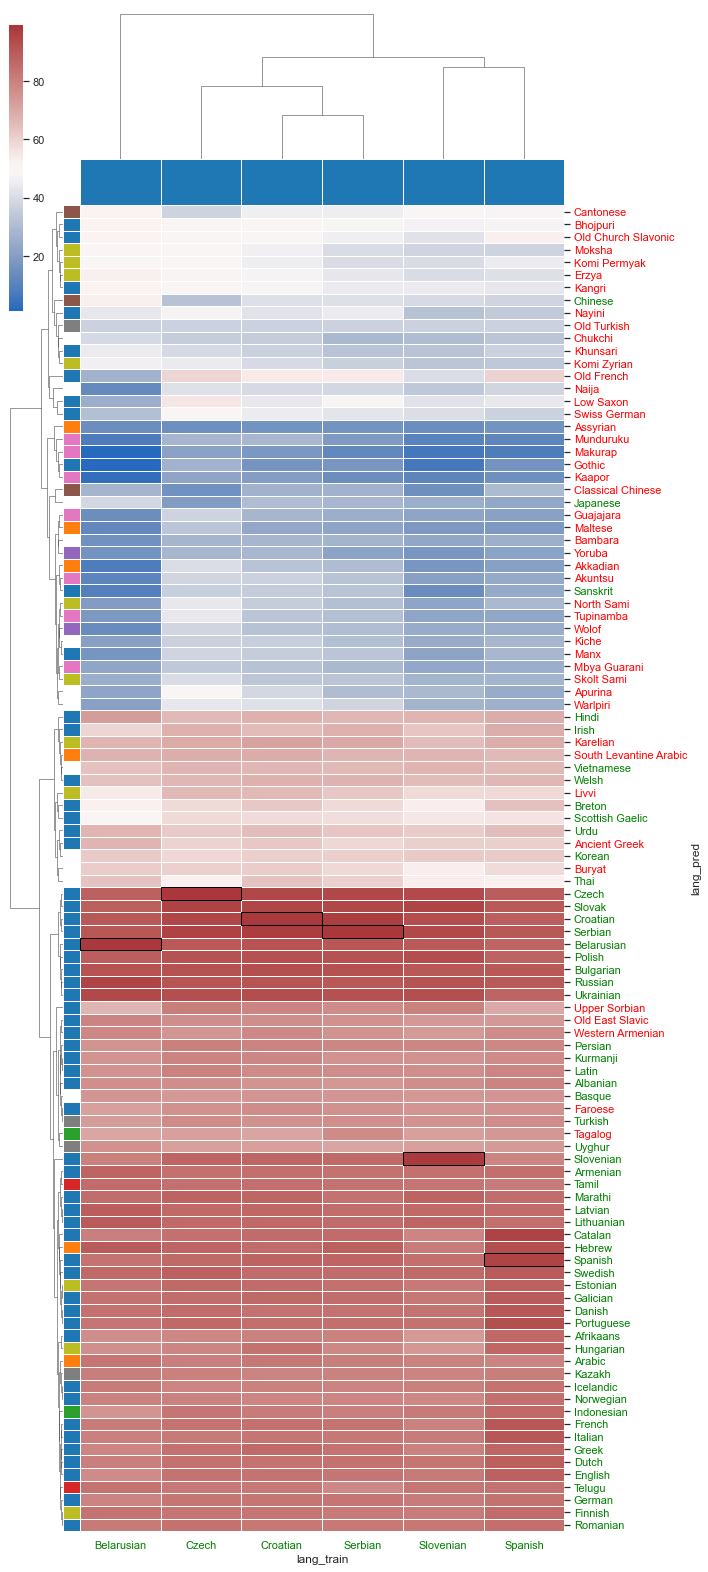

In [30]:
create_clustermap(table.loc[:,masked_table.max(axis=0) >= 95], figsize=(10,22))

## Performance per family

<AxesSubplot:xlabel='lang_train_family', ylabel='score'>

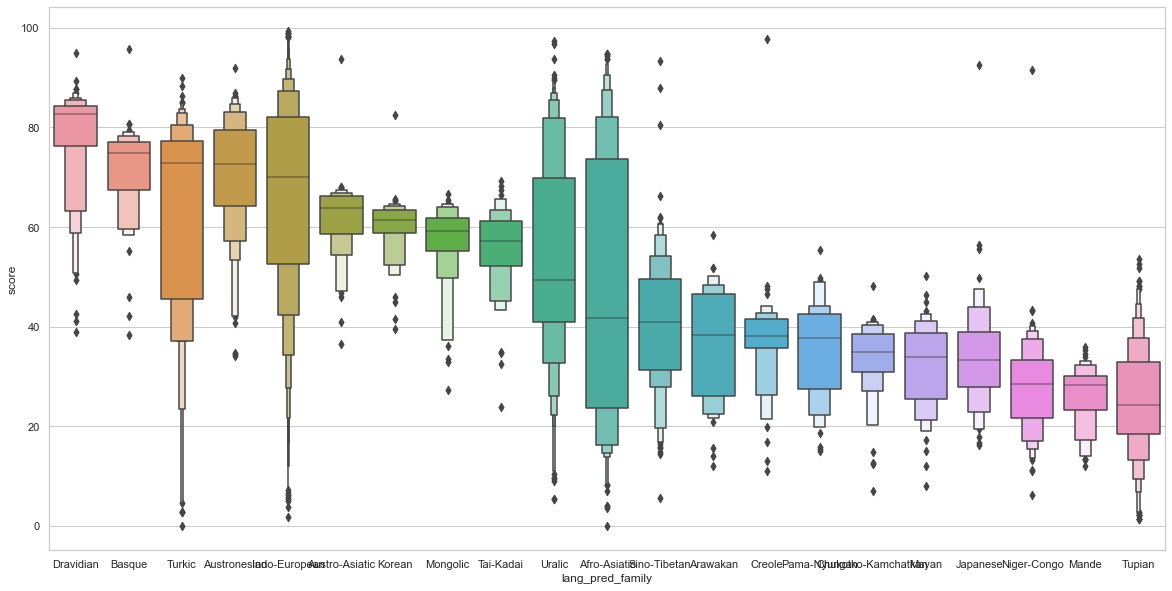

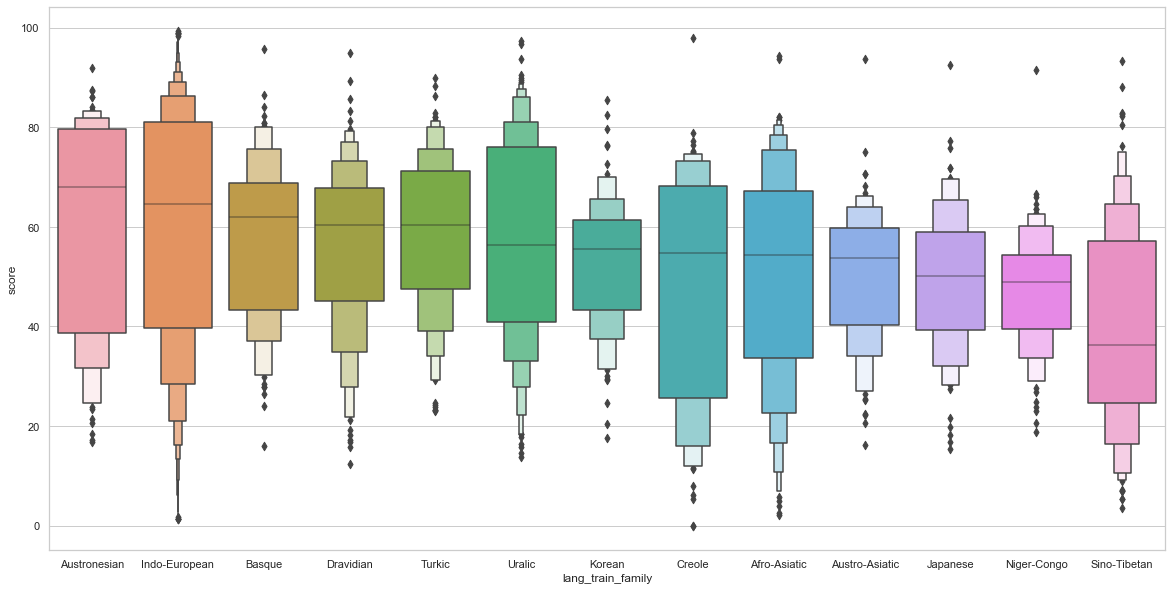

In [31]:
pred_order = df.groupby("lang_pred_family").score.median().sort_values(ascending=False).index.tolist()
train_order = df.groupby("lang_train_family").score.median().sort_values(ascending=False).index.tolist()

plt.figure(figsize=(20, 10))
sns.boxenplot(x="lang_pred_family", y="score", order=pred_order, data=df)

plt.figure(figsize=(20, 10))
sns.boxenplot(x="lang_train_family", y="score", order=train_order, data=df)

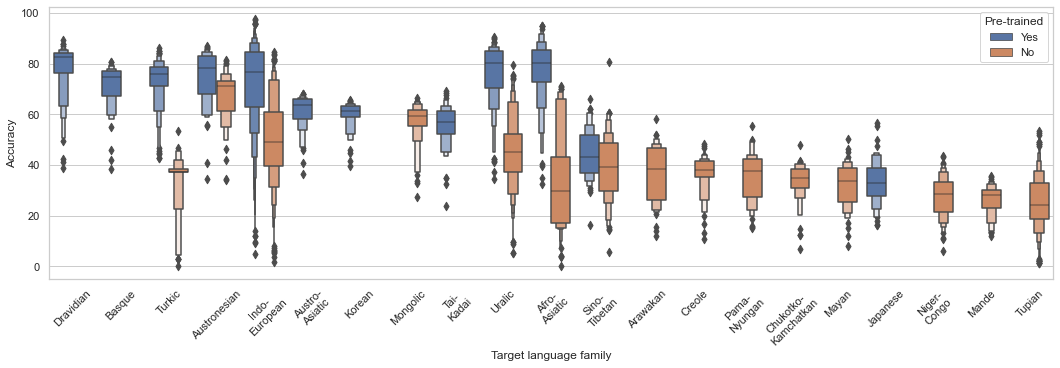

In [32]:

# plt.figure(figsize=(5, 10))
# ax = sns.boxenplot(x="lang_train_pretrained", y="score", data=df)

# plt.figure(figsize=(5, 10))
# ax = sns.boxenplot(x="lang_pred_pretrained", y="score", data=df)

df_ = df.copy()
df_["Pre-trained"] = df_["lang_pred_pretrained"].map(lambda x: "Yes" if x else "No")
df_["Target language family"] = df_["lang_pred_family"].map(lambda x: x.replace("-", "-\n"))
df_["score"] = df_.apply(lambda x: np.nan if x.lang_train == x.lang_pred else x.score, axis=1)

plt.figure(figsize=(18, 5))
pred_order = df_.groupby("Target language family").score.median().sort_values(ascending=False).index.tolist()
ax = sns.boxenplot(x="Target language family", y="score", hue="Pre-trained", order=pred_order, data=df_)
plt.xticks(rotation=45)

# plt.xticks(size=10)
plt.ylabel("Accuracy")
plt.savefig("plots/target-family-boxes.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

None

# plt.figure(figsize=(30, 10))
# ax = sns.boxenplot(x="lang_train_family", y="score", hue="lang_train_pretrained", order=train_order, data=df)
# plt.xticks(rotation=45)


(66,)


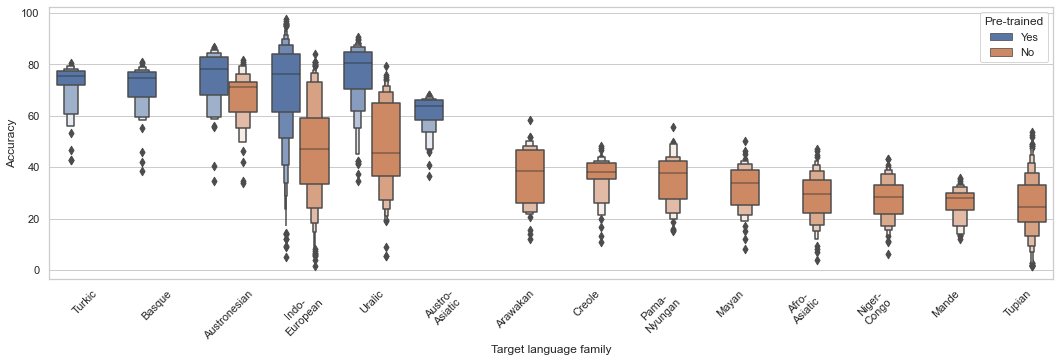

In [33]:
df_ = df.copy()
df_ = df_.loc[df.lang_pred_script == "latin"]
print(df_.lang_pred.unique().shape)

df_["Pre-trained"] = df_["lang_pred_pretrained"].map(lambda x: "Yes" if x else "No")
df_["Target language family"] = df_["lang_pred_family"].map(lambda x: x.replace("-", "-\n"))
df_["score"] = df_.apply(lambda x: np.nan if x.lang_train == x.lang_pred else x.score, axis=1)

plt.figure(figsize=(18, 5))
pred_order = df_.groupby("Target language family").score.median().sort_values(ascending=False).index.tolist()
ax = sns.boxenplot(x="Target language family", y="score", hue="Pre-trained", order=pred_order, data=df_)
plt.xticks(rotation=45)

# plt.xticks(size=10)
plt.ylabel("Accuracy")
# plt.savefig("plots/target-family-boxedsadsas.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

None

In [34]:
df_ = df.reset_index().groupby("lang_pred_family")["score"].max()
for n in ["Tupian", "Mande", "Niger-Congo", "Mayan", "Chukotko-Kamchatkan", "Pama-Nyungan", "Arawakan"]:
    print(n, df_[n])

Tupian 53.59712230215828
Mande 35.80988208059032
Niger-Congo 91.48844242817025
Mayan 50.11780545270953
Chukotko-Kamchatkan 48.0666903157148
Pama-Nyungan 55.465587044534416
Arawakan 58.333333333333336


In [36]:
lang_fams

{'Abaza': 'Northwest Caucasian',
 'Afrikaans': 'Indo-European',
 'Akkadian': 'Afro-Asiatic',
 'Akuntsu': 'Tupian',
 'Albanian': 'Indo-European',
 'Amharic': 'Afro-Asiatic',
 'Ancient Greek': 'Indo-European',
 'Apurina': 'Arawakan',
 'Arabic': 'Afro-Asiatic',
 'Armenian': 'Indo-European',
 'Assyrian': 'Afro-Asiatic',
 'Bambara': 'Mande',
 'Basque': 'Basque',
 'Beja': 'Afro-Asiatic',
 'Belarusian': 'Indo-European',
 'Bhojpuri': 'Indo-European',
 'Breton': 'Indo-European',
 'Bulgarian': 'Indo-European',
 'Buryat': 'Mongolic',
 'Cantonese': 'Sino-Tibetan',
 'Catalan': 'Indo-European',
 'Chinese': 'Sino-Tibetan',
 'Chukchi': 'Chukotko-Kamchatkan',
 'Classical Chinese': 'Sino-Tibetan',
 'Coptic': 'Afro-Asiatic',
 'Croatian': 'Indo-European',
 'Czech': 'Indo-European',
 'Danish': 'Indo-European',
 'Dutch': 'Indo-European',
 'English': 'Indo-European',
 'Erzya': 'Uralic',
 'Estonian': 'Uralic',
 'Faroese': 'Indo-European',
 'Finnish': 'Uralic',
 'French': 'Indo-European',
 'Frisian Dutch': 'Co

lang_pred_family
Japanese (1)          40.768113
Sino-Tibetan (3)      48.552815
Tai-Kadai (1)         52.647884
Korean (1)            60.471829
Austro-Asiatic (1)    60.574641
Indo-European (56)    63.120185
Austronesian (2)      68.444644
Basque (1)            68.517234
Turkic (4)            69.395477
Uralic (11)           69.427211
Afro-Asiatic (6)      69.640395
Dravidian (2)         74.420332
dtype: float64

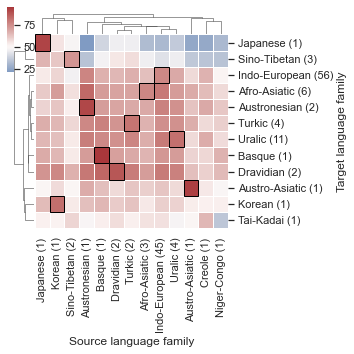

In [55]:
# df_ = df.loc[df.lang_train_pretrained & df.lang_pred_pretrained]


count_train = df.groupby(["lang_train_family", "lang_train"]).count().score
count_pred = df.groupby(["lang_pred_family", "lang_pred"]).count().score

df_ = df.copy()
df_["lang_pred_family"] = df.lang_pred_family.map(lambda x: f"{x} ({count_pred.loc[x].count()})")
df_["lang_train_family"] = df.lang_train_family.map(lambda x: f"{x} ({count_train.loc[x].count()})")

df_ = df_.loc[df.lang_pred_pretrained]
df_ = df_.groupby(["lang_pred_family", "lang_train_family"]).mean().reset_index()
table_ = df_.pivot(index='lang_pred_family', columns='lang_train_family', values='score')

# color_ticks=[
#     "Basque", "Afro-Asiatic", "IE, Slavic", "Dravidian", "IE, Indic", "Turkic", "Uralic",
#     "IE, Armenian", "IE, Baltic", "IE, Iranian", "IE, Albanian", "IE, Greek", "Austronesian",
#     "IE, Germanic", "IE, Italic", "Sino-Tibetan", "IE, Celtic", "Austro-Asiatic", "Tai-Kadai", "Korean", "Mongolic", "Japanese"
# ], 
ax = create_clustermap(table_,
                    color_ticks=False,
                    color_families=False,
                  map_families=False, figsize=(5, 5))
ax.set_xlabel("Source language family")
ax.set_ylabel("Target language family")

plt.savefig("plots/heatmap-families.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

table_.mean(1).sort_values()
# table_.std(1).loc[table_.mean(1) > 45].sort_values()
# table_.std(1).loc[table_.mean(1) > 45].sort_values()
# table_.std(0)

In [34]:
df.loc[~df.lang_pred_pretrained].groupby(["lang_train_family", "lang_pred_family"]).count().loc["Uralic"].lang_pred.sort_values() / 4

lang_pred_family
Arawakan                1.0
Austronesian            1.0
Chukotko-Kamchatkan     1.0
Creole                  1.0
Mande                   1.0
Mayan                   1.0
Mongolic                1.0
Pama-Nyungan            1.0
Turkic                  1.0
Niger-Congo             2.0
Sino-Tibetan            2.0
Afro-Asiatic            4.0
Tupian                  7.0
Uralic                  8.0
Indo-European          15.0
Name: lang_pred, dtype: float64

## Writing systems

latin         66
cyrillic      13
arabic         7
devanagari     4
chinese        3
armenian       2
greek          2
hangul         1
syriac         1
thai           1
tamil          1
kana           1
telugu         1
old turkic     1
hebrew         1
Name: lang_pred_script, dtype: int64


<AxesSubplot:xlabel='script', ylabel='count'>

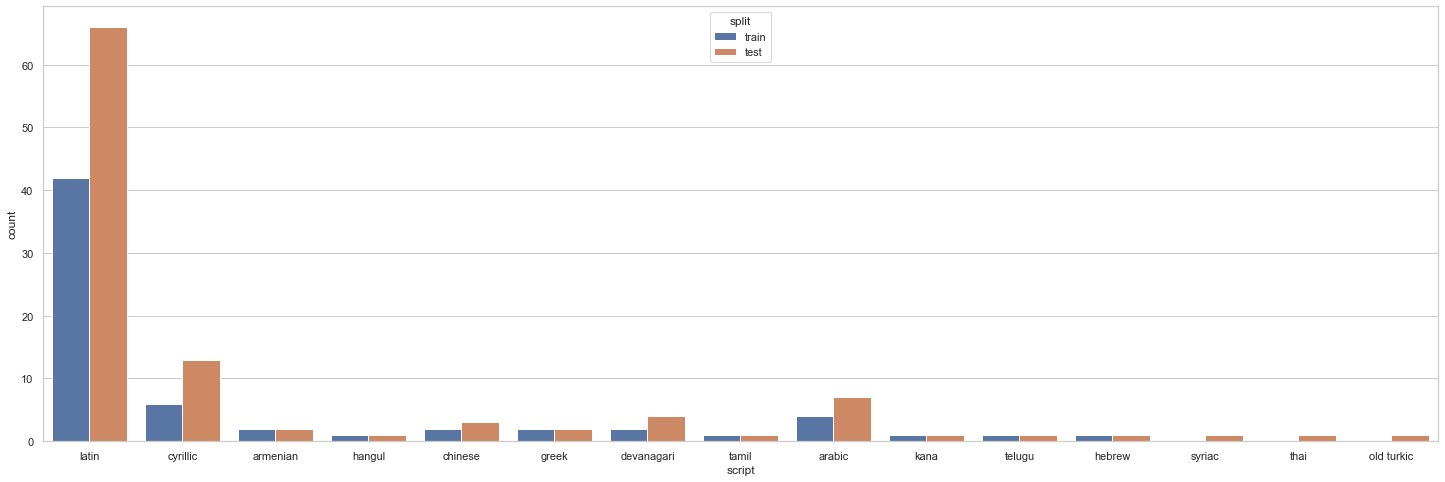

In [35]:
pred_df = df[["lang_pred", "lang_pred_script"]].drop_duplicates()
pred_df["split"] = "test"
pred_df["script"] = pred_df["lang_pred_script"]

train_df = df[["lang_train", "lang_train_script"]].drop_duplicates()
train_df["split"] = "train"
train_df["script"] = train_df["lang_train_script"]

df_ = pd.concat([train_df, pred_df])

print(pred_df.lang_pred_script.value_counts())

plt.figure(figsize=(25,8))
sns.countplot(x="script", hue="split", data=df_)

{'latin': 66,
 'cyrillic': 13,
 'arabic': 7,
 'devanagari': 4,
 'chinese': 3,
 'armenian': 2,
 'greek': 2,
 'hangul': 1,
 'syriac': 1,
 'thai': 1,
 'tamil': 1,
 'kana': 1,
 'telugu': 1,
 'old turkic': 1,
 'hebrew': 1}

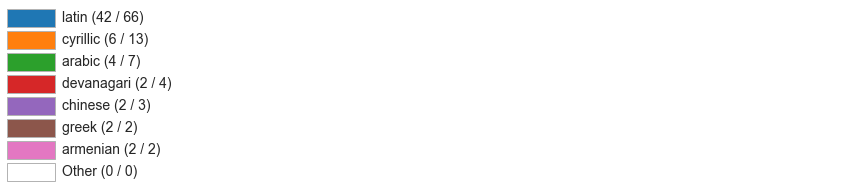

In [36]:
script_colors = {
 'latin': tab10(0),
 'cyrillic': tab10(1),
 'arabic': tab10(2),
 'devanagari': tab10(3),
 'chinese': tab10(4),
 'greek': tab10(5),
 'armenian': tab10(6),
 'Other': (1,1,1,1),
}

pred_script_counts = dict(df[["lang_pred", "lang_pred_script"]].drop_duplicates().lang_pred_script.value_counts())
train_script_counts = dict(df[["lang_train", "lang_train_script"]].drop_duplicates().lang_train_script.value_counts())
plot_colortable(script_colors, pred_script_counts, train_script_counts)

# sorted(row_families.unique())
pred_script_counts

Index(['Arabic (4)', 'Armenian (2)', 'Chinese (2)', 'Cyrillic (6)',
       'Devanagari (2)', 'Greek (2)', 'Hangul (1)', 'Hebrew (1)', 'Kana (1)',
       'Latin (42)', 'Tamil (1)', 'Telugu (1)'],
      dtype='object', name='lang_train_script')

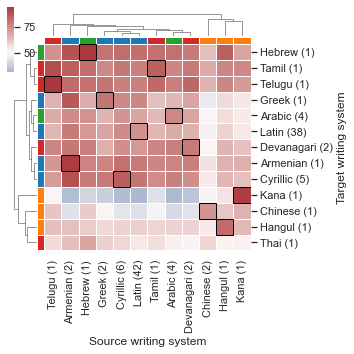

In [56]:

df_ = df.copy()
df_ = df_.loc[df.lang_pred_pretrained]

count_train = df_.groupby(["lang_train_script", "lang_train"]).count().score
count_pred = df_.groupby(["lang_pred_script", "lang_pred"]).count().score

df_["lang_pred_script"] = df_.lang_pred_script.map(lambda x: f"{x.capitalize()} ({count_pred.loc[x].count()})")
df_["lang_train_script"] = df_.lang_train_script.map(lambda x: f"{x.capitalize()} ({count_train.loc[x].count()})")

df_ = df_.groupby(["lang_pred_script", "lang_train_script"]).mean().reset_index()
table_ = df_.pivot(index='lang_pred_script', columns='lang_train_script', values='score')


# {
#     "Armenian", "Hebrew", "Tamil", "Telugu", "Hangul", "Greek", "Thai", "Arabic", "Devanagari", "Cyrillic", "Latin", "Chinese", "Kana"
# }
color_families = {
    "Armenian": tab10(0), "Hebrew": tab10(2), "Tamil": tab10(3), "Telugu": tab10(3), "Hangul": tab10(1), "Greek": tab10(0), "Arabic": tab10(2), "Devanagari": tab10(3), "Cyrillic": tab10(0), "Latin": tab10(0), "Chinese": tab10(1), "Kana": tab10(1), "Other": (1,1,1,1), "Thai": tab10(3),
}
ax = create_clustermap(table_,
                  map_families=False,
                  color_families=color_families,
                  color_ticks=False, figsize=(5, 5))
ax.set_xlabel("Source writing system")
ax.set_ylabel("Target writing system")

plt.savefig("plots/heatmap-scripts.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

table_.columns

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

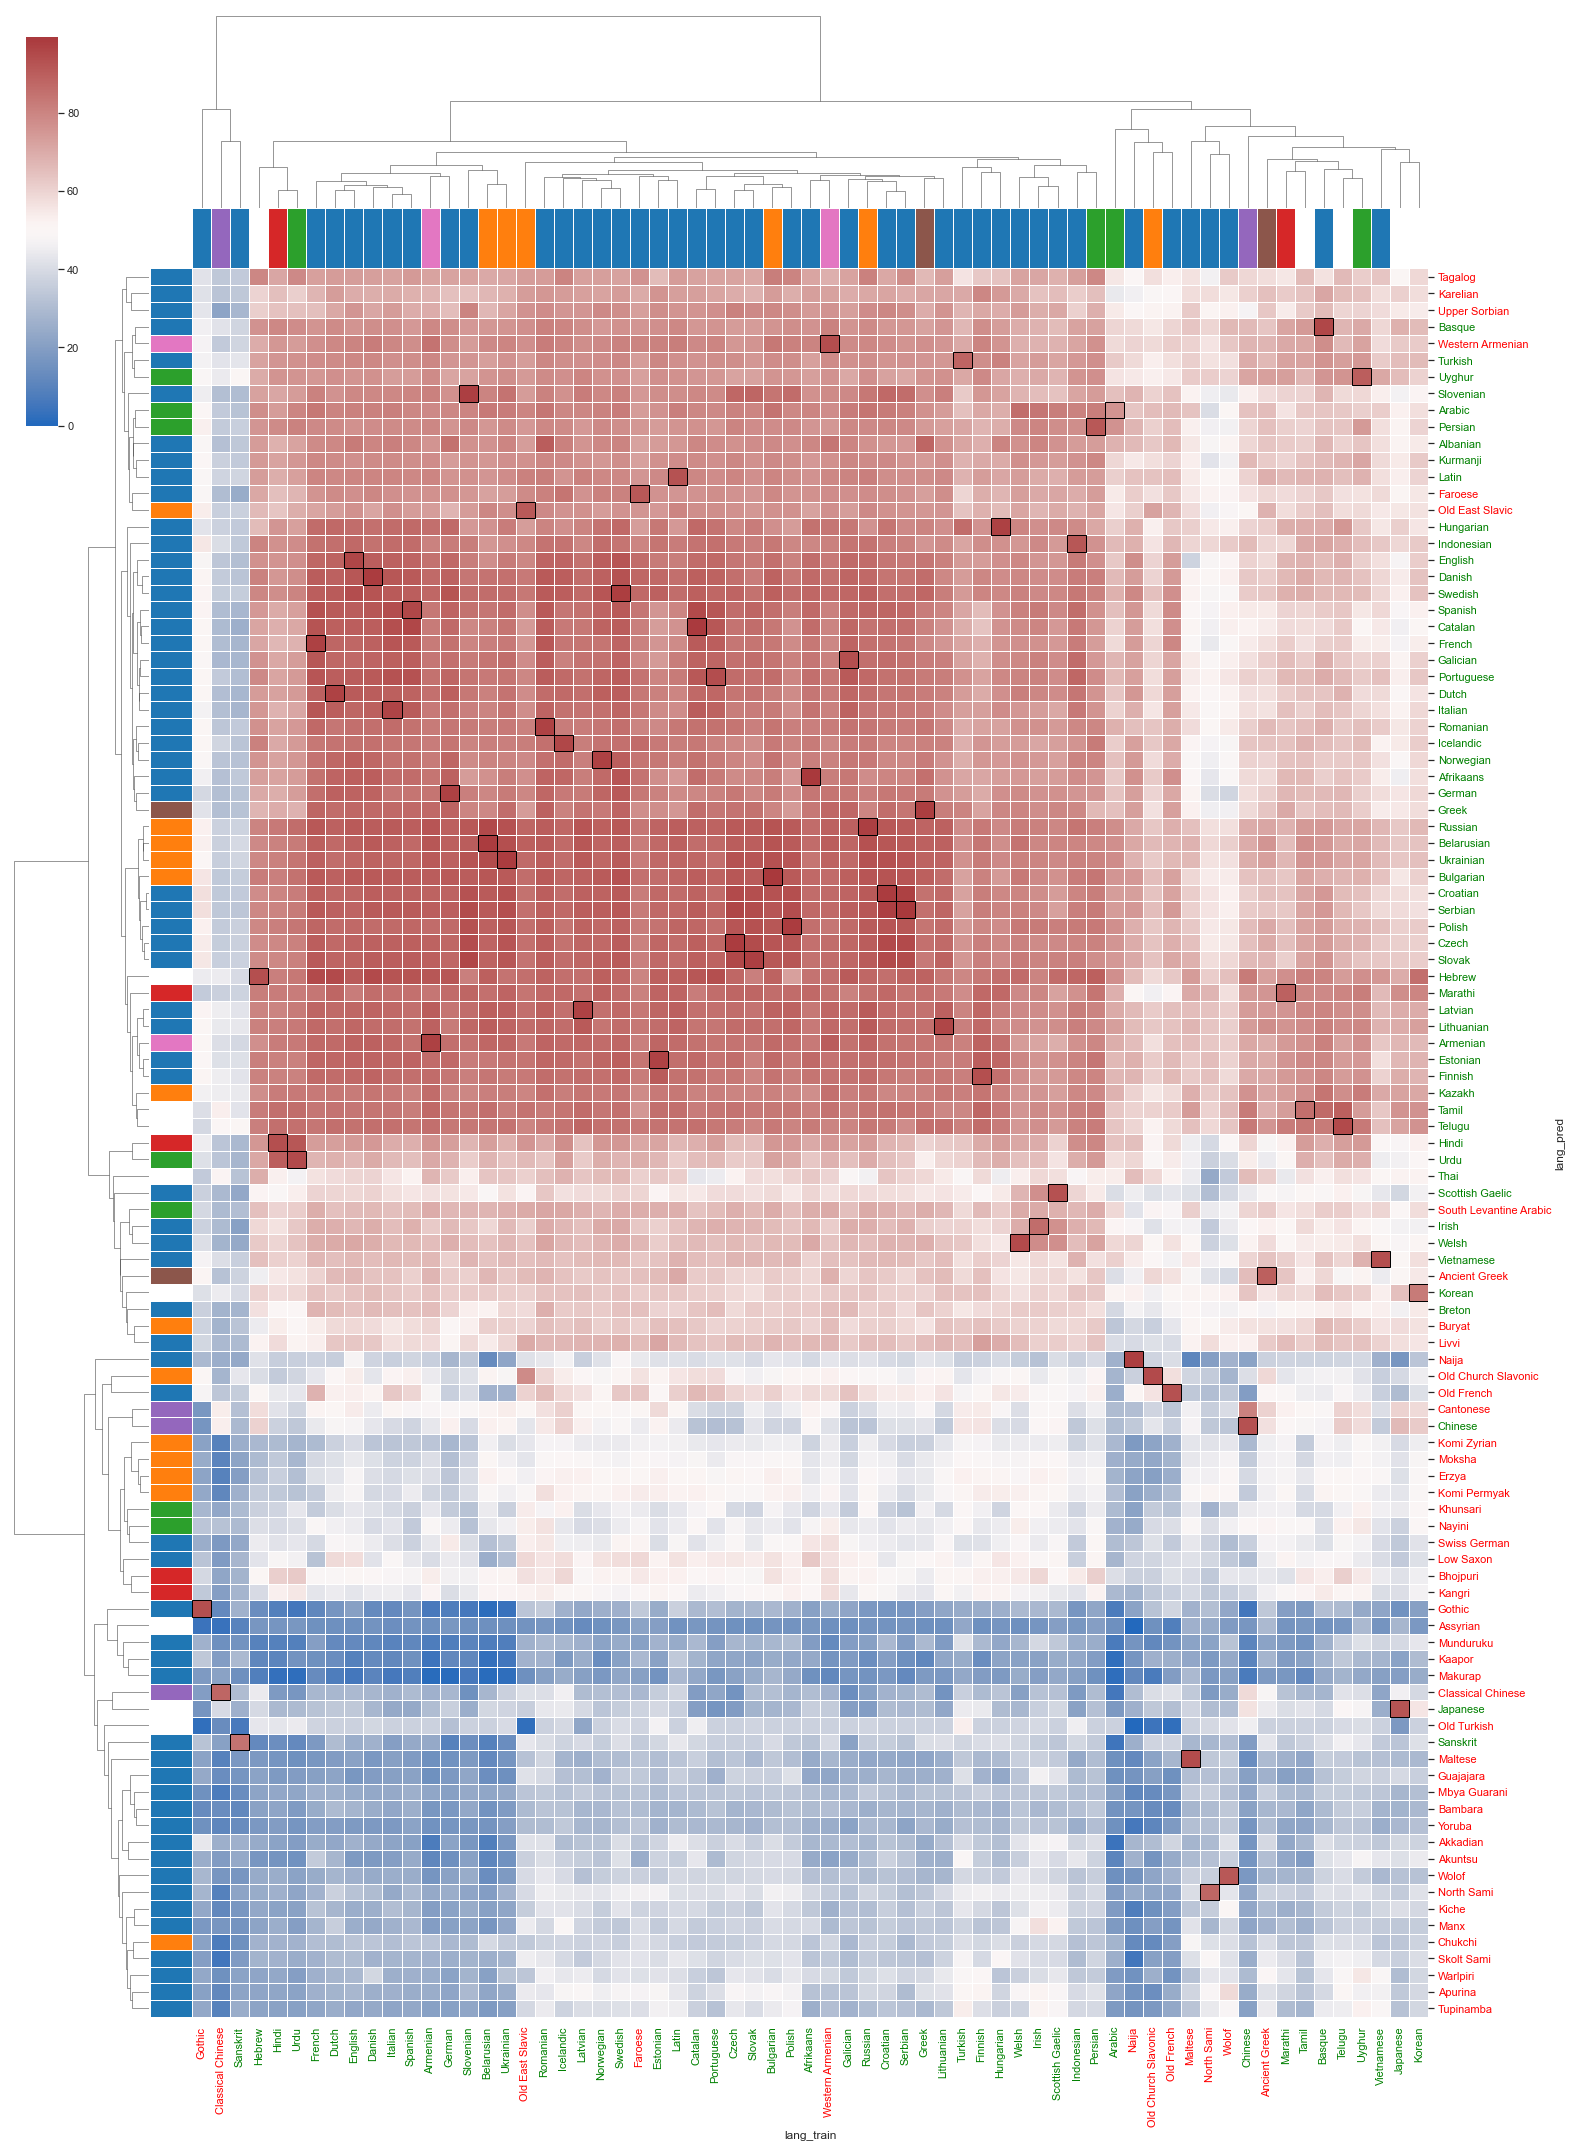

In [38]:
create_clustermap(table, figsize=(22, 30), map_families=ud_langs_scripts, color_families=script_colors)

<AxesSubplot:xlabel='lang_train_script', ylabel='score'>

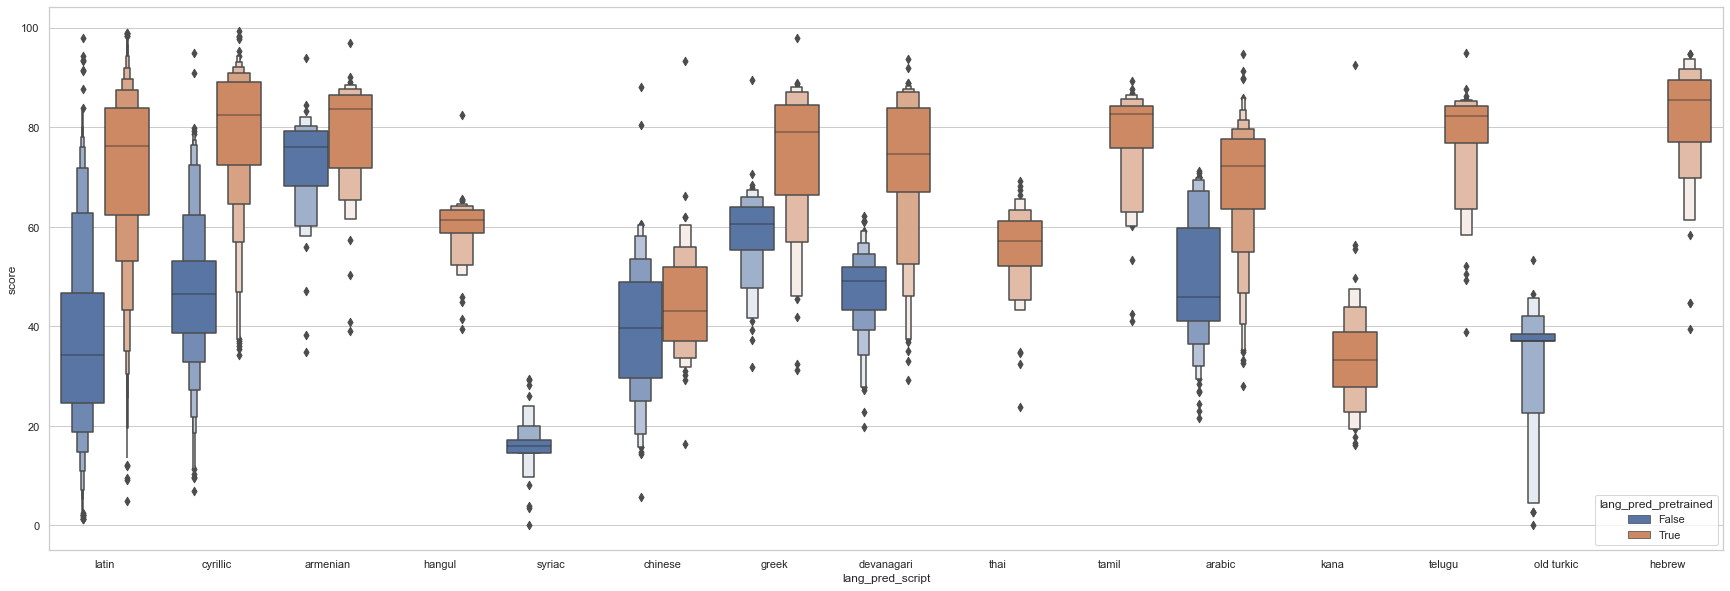

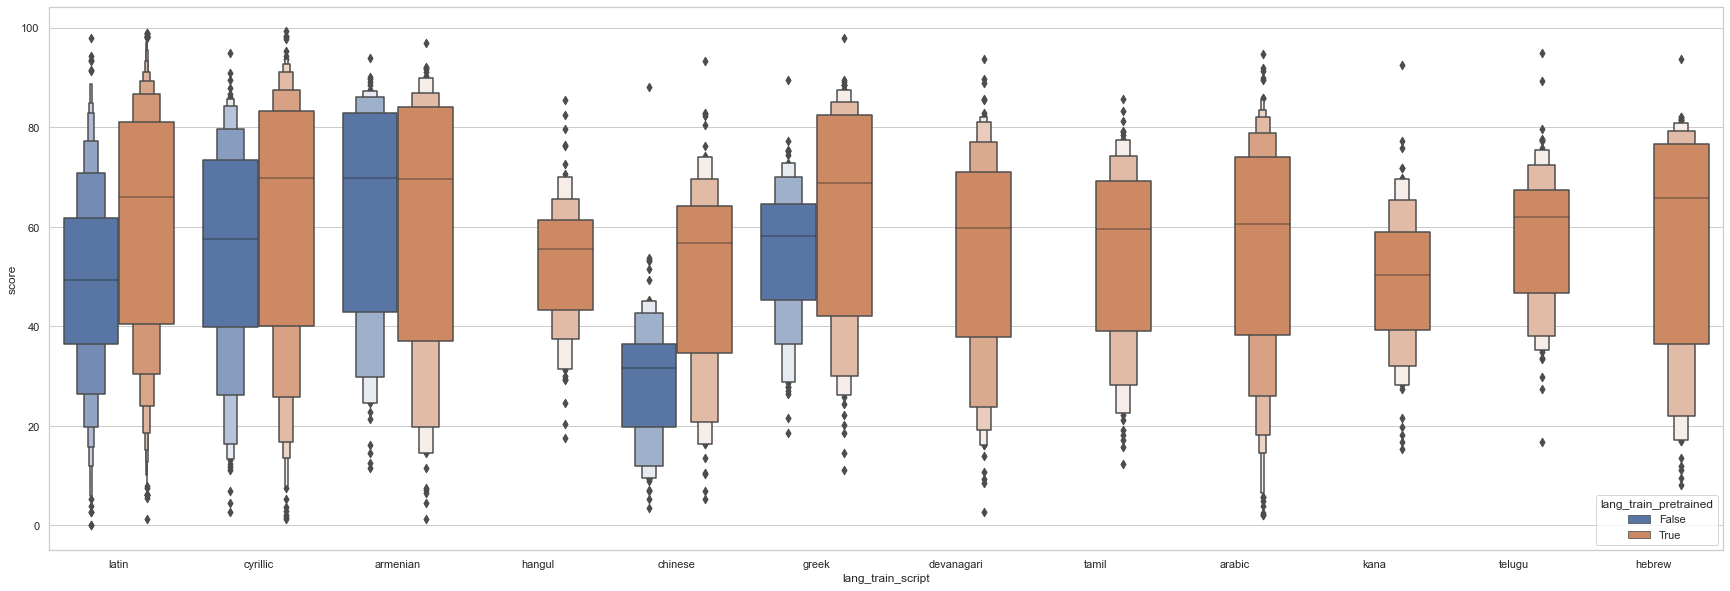

In [39]:
# df_ = df.groupby(["lang_pred_script", "lang_train_script", "lang_pred", "lang_train"]).score.mean().reset_index()

plt.figure(figsize=(30,10))
sns.boxenplot(x="lang_pred_script", y="score", hue="lang_pred_pretrained", data=df)

plt.figure(figsize=(30,10))
sns.boxenplot(x="lang_train_script", y="score", hue="lang_train_pretrained", data=df)

## Latin

<AxesSubplot:xlabel='lang_train_family', ylabel='score'>

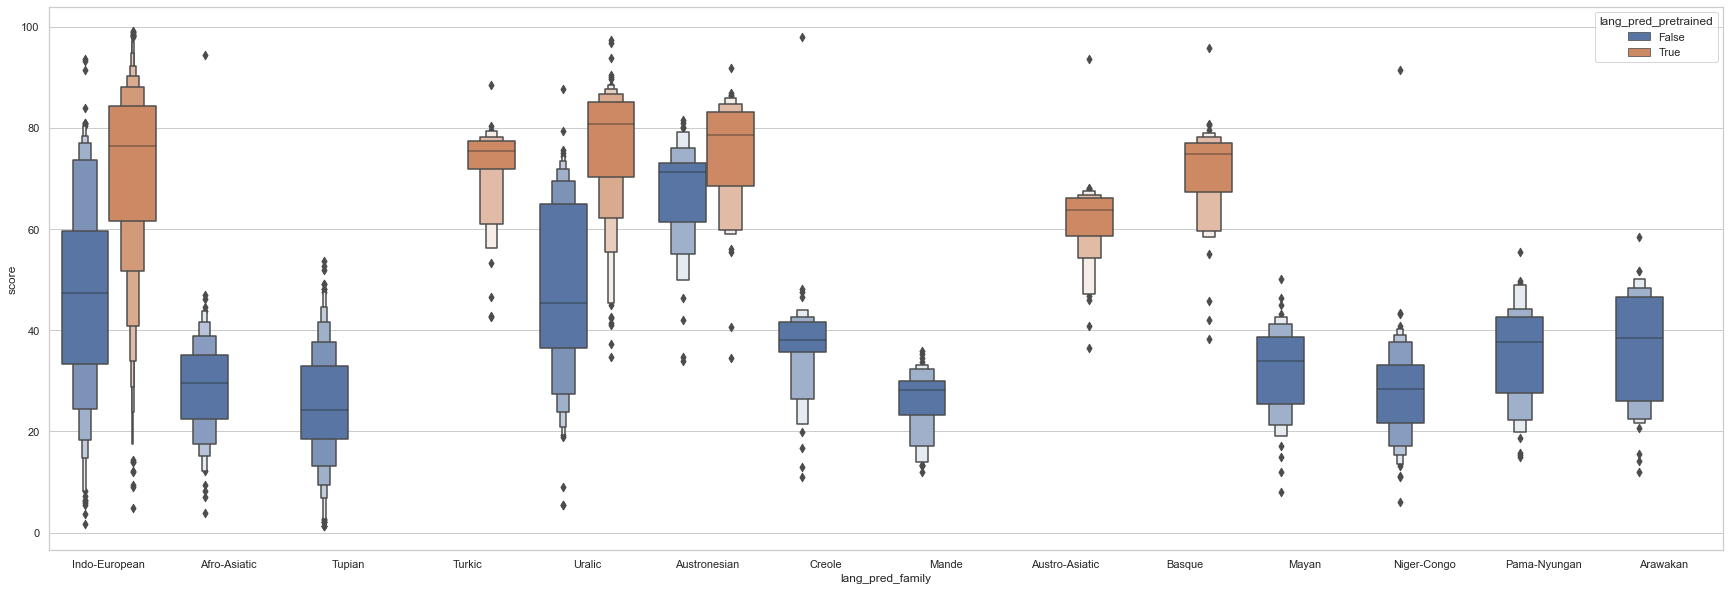

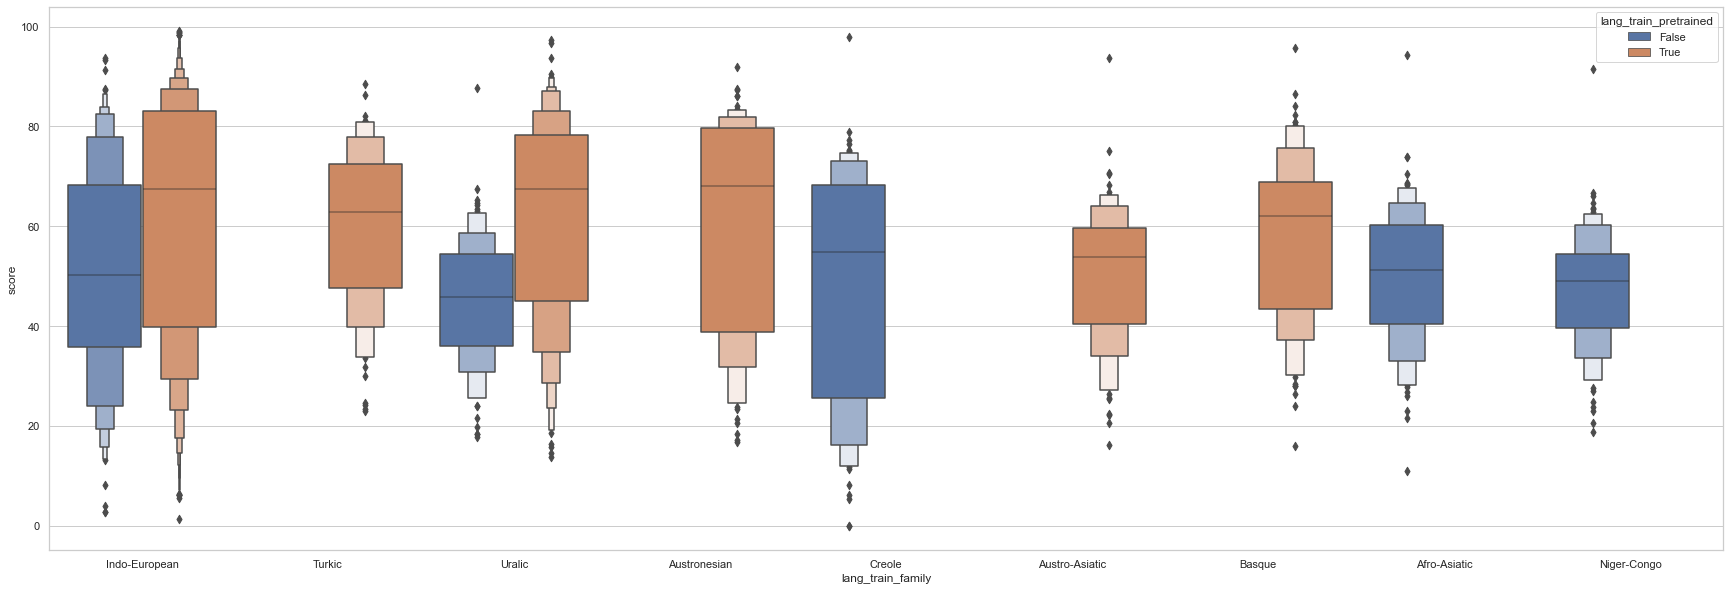

In [40]:
plt.figure(figsize=(30,10))
sns.boxenplot(x="lang_pred_family", y="score", hue="lang_pred_pretrained", data=df.loc[df.lang_pred_script == "latin"])

plt.figure(figsize=(30,10))
sns.boxenplot(x="lang_train_family", y="score", hue="lang_train_pretrained", data=df.loc[df.lang_train_script == "latin"])

## Perfect pairs

In [41]:
masked_table = table.mask(table.apply(lambda x: x.name == x.index))
pair_idx = np.nanargmax(masked_table.to_numpy(), axis=1)

pred_names = masked_table.index.tolist()
train_names = masked_table.columns.tolist()
pairs = []
for i, j in enumerate(pair_idx):
    pred_name = pred_names[i]
    train_name = train_names[j]
    pairs.append((pred_name, train_name))
    if (train_name, pred_name) in pairs:
        print((train_name, pred_name), (ud_langs_scripts[train_name], ud_langs_scripts[pred_name]),
              (lang_fams[train_name], lang_fams[pred_name]),
              (table.loc[train_name, train_name], table.loc[pred_name, pred_name], table.loc[train_name, pred_name],
               table.loc[pred_name, train_name]))


('Estonian', 'Finnish') ('latin', 'latin') ('Uralic', 'Uralic') (96.79797767010744, 93.7658551626512, 89.97585519599424, 90.50582348736492)
('Faroese', 'Icelandic') ('latin', 'latin') ('Indo-European', 'Indo-European') (91.41384309724532, 95.6444734450374, 83.89088761209257, 86.45102654331058)
('French', 'Italian') ('latin', 'latin') ('Indo-European', 'Indo-European') (97.13443520370564, 96.3051307235396, 92.16549110432678, 91.7122679014078)
('Chinese', 'Japanese') ('chinese', 'kana') ('Sino-Tibetan', 'Japanese') (93.42326072016492, 92.63619575253924, 66.21489875177804, 56.39605085588465)
('Irish', 'Scottish Gaelic') ('latin', 'latin') ('Indo-European', 'Indo-European') (86.04651162790698, 93.27395577395578, 76.61890220029754, 77.05773955773955)
('Croatian', 'Serbian') ('latin', 'latin') ('Indo-European', 'Indo-European') (98.27287716405606, 99.0631293231766, 97.03215169002472, 97.53086419753086)
('Catalan', 'Spanish') ('latin', 'latin') ('Indo-European', 'Indo-European') (98.718320758

### Perfect triplets

In [42]:
masked_table = table.mask(table.apply(lambda x: x.name == x.index))

masked_table_sorted = np.argsort(np.nan_to_num(masked_table.to_numpy()))

pred_names = masked_table.index.tolist()
train_names = masked_table.columns.tolist()

clustersets = {i: [] for i in range(2, masked_table.shape[1])}

ud_langs_inv = {v: k for k, v in ud_langs.items()}

for pred_i in range(masked_table.shape[0]):
    c = {pred_names[pred_i]}
    for i, clusterset in clustersets.items():
        c.add(train_names[masked_table_sorted[pred_i, -(i - 1)]])
        clusterset.append(set(c))
        if clusterset.count(c) == i:
            c_ = sorted(c)
            print('"' + "-".join([ud_langs_inv[l] for l in c_]) + "\",  #", " / ".join(c_))

"et-fi",  # Estonian / Finnish
"fo-is",  # Faroese / Icelandic
"fr-it",  # French / Italian
"zh-ja",  # Chinese / Japanese
"ga-gd",  # Irish / Scottish Gaelic
"hr-sr",  # Croatian / Serbian
"hr-cs-sr",  # Croatian / Czech / Serbian
"ca-es",  # Catalan / Spanish
"en-sv",  # English / Swedish
"be-uk",  # Belarusian / Ukrainian
"hi-ur",  # Hindi / Urdu
"hy-hyw",  # Armenian / Western Armenian


In [43]:
# masked_table = table.mask(table.apply(lambda x: x.name == x.index))
# pair_idx = np.nanargmax(masked_table.to_numpy(), axis=1)

# pred_names = masked_table.index.tolist()
# train_names = masked_table.columns.tolist()

# cluster_idx = {}
# clusters = []
# for pred_names_i, train_name_i in enumerate(pair_idx):
#     pred_name = pred_names[pred_names_i]
#     train_name = train_names[train_name_i]

#     train_i = cluster_idx.get(train_name, None)
#     pred_i = cluster_idx.get(pred_name, None)
#     if train_i is not None and pred_i is not None:
#         clusters[train_i] = clusters[train_i] | clusters[pred_i]
#         clusters[pred_i] = None

#         cluster_idx[pred_name] = train_i
#         for name, i in cluster_idx.items():
#             if i == pred_i:
#                 cluster_idx[name] = train_i
#     elif train_i is not None:
#         clusters[train_i].add(pred_name)
#         cluster_idx[pred_name] = train_i
#     elif pred_i is not None:
#         clusters[pred_i].add(train_name)
#         cluster_idx[train_name] = pred_i
#     else:
#         cluster_i = len(clusters)
#         clusters.append({train_name, pred_name})
#         cluster_idx[train_name] = pred_i
#         cluster_idx[pred_name] = train_i


# clusters = [c for c in clusters if c is not None]
# for cluster in clusters:
#     print(cluster)

Self-training is always better for these languages

### Perfect siblings
Ethnologue siblings with no competing siblings in UD. At least partially mutually intelligable (https://en.wikipedia.org/wiki/Mutual_intelligibility)

 - Estionian - Finish: Uralic > Finnic (direct siblings) (https://www.ethnologue.com/subgroups/finnic)
 - Faroese - Icelandic: IE > Germanic > North > West Scandinavian (direct siblings) (https://www.ethnologue.com/subgroups/west-scandinavian)
 - French - Italian: IE > Italic > Romance > Italo-Western > Western > Gallo-Iberian > Gallo-Romance (https://www.ethnologue.com/subgroups/gallo-romance)
 - Irish - Scottish Gaelic: IE > Celtic > Insular > Goidelic (https://www.ethnologue.com/subgroups/goidelic)
 - Croatian - Serbian: IE > Balto-Salvic > Slavic > South > Western (https://www.ethnologue.com/subgroups/western-25) (https://www.ethnologue.com/language/hbs)
 - Belarusian - Ukranian: IE > Balto-Slavic > Slavic > East (https://www.ethnologue.com/subgroups/east-4) russian is competing
 - Hindi - Urdu: IE > Indo-Iranian > ... > Hindustani (https://www.ethnologue.com/subgroups/hindustani)
 - Armenian - Western Armenian: IE > Armenian (https://www.ethnologue.com/subgroups/armenian)

## Almost perfect
 - Catalan - Spanish: IE > Italic > Romance > Italo-Western > Western > Gallo-Iberian > Ibero-Romance (https://www.ethnologue.com/subgroups/ibero-romance) (portuguese is actually competing)
 - English - Swedish: IE > Germanic

### Other
 - Chinese - Japanese: officially, both unrelated mini language families


## Reasons for failure

0            Indo-European
1                   Turkic
2            Indo-European
3            Indo-European
4            Indo-European
5            Indo-European
6                Tai-Kadai
7            Indo-European
8            Indo-European
9            Indo-European
10           Indo-European
11           Indo-European
12            Afro-Asiatic
13           Indo-European
14           Indo-European
15           Indo-European
16           Indo-European
17           Indo-European
18           Indo-European
19                Japanese
20           Indo-European
21            Austronesian
22           Indo-European
23                  Turkic
24                 Conlang
25           Indo-European
26           Indo-European
27           Indo-European
28           Indo-European
29            Sino-Tibetan
30           Indo-European
31               Dravidian
32          Austro-Asiatic
33           Indo-European
34                  Uralic
35           Indo-European
36            Austronesian
3

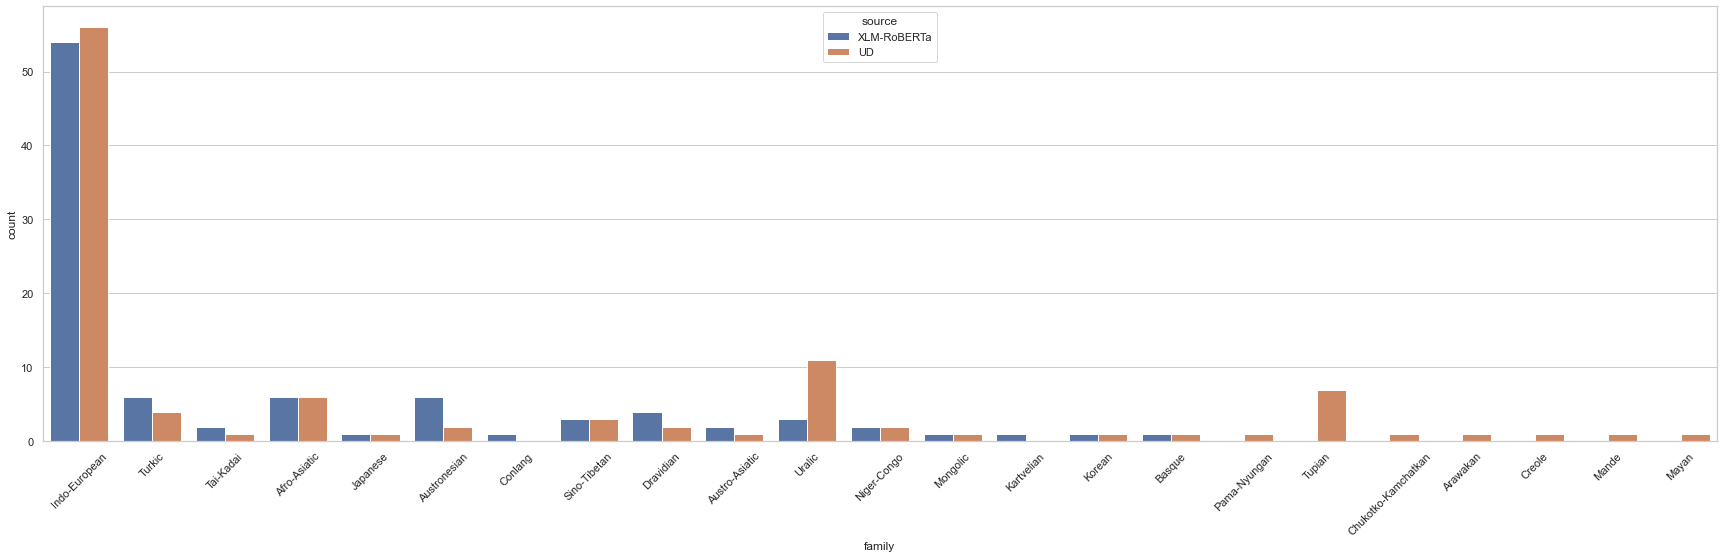

In [44]:
rows = [(lang, lang_fams[lang], "XLM-RoBERTa") for lang in model_lang_names] + [(lang, lang_fams[lang], "UD") for lang in ud_lang_names]
df_ = pd.DataFrame(rows, columns=["language", "family", "source"])
df_

plt.figure(figsize=(30,8))
plt.xticks(rotation=45)
fig = sns.countplot(x="family", hue="source", data=df_)
df_.family

lang_train,Afrikaans,Ancient Greek,Arabic,Armenian,Basque,Belarusian,Bulgarian,Catalan,Chinese,Classical Chinese,...,Tamil,Telugu,Turkish,Ukrainian,Urdu,Uyghur,Vietnamese,Welsh,Western Armenian,Wolof
lang_pred,,,,,,,,,,,,,,,,,,,,,
Cantonese,52.363845,60.231355,30.140825,48.18221,49.030033,51.652536,42.11812,40.508694,80.550366,53.66432,...,50.316137,60.432533,54.27504,53.764909,38.159218,57.436413,40.738612,40.745797,48.483978,40.185371


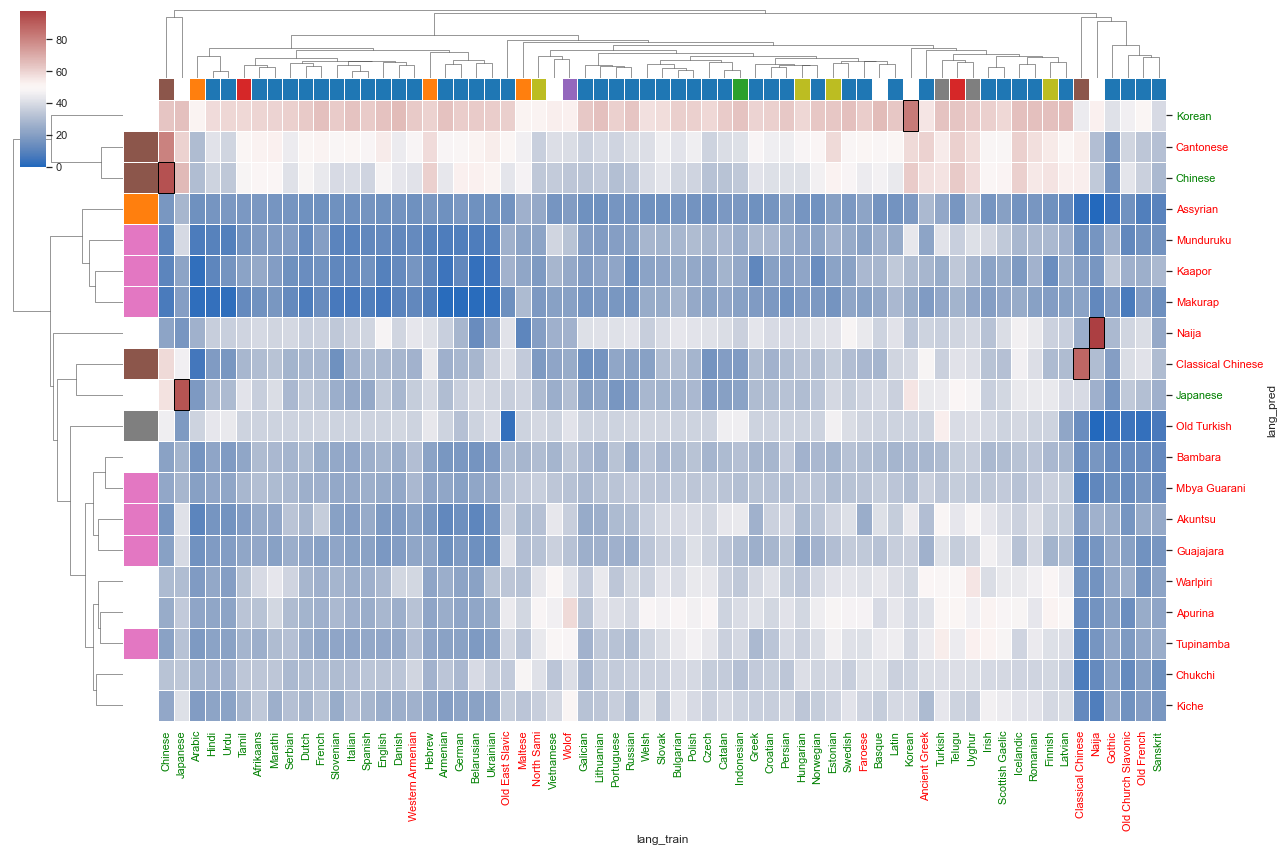

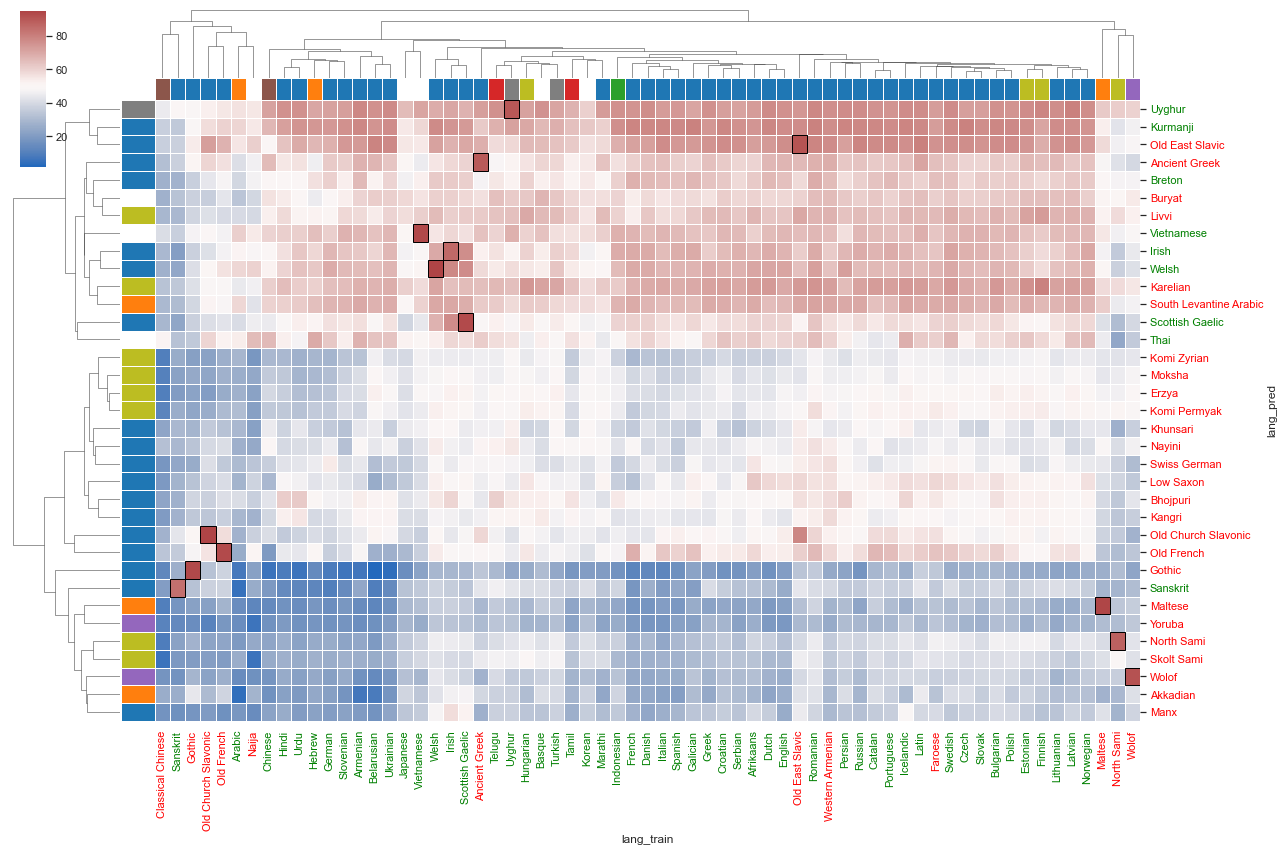

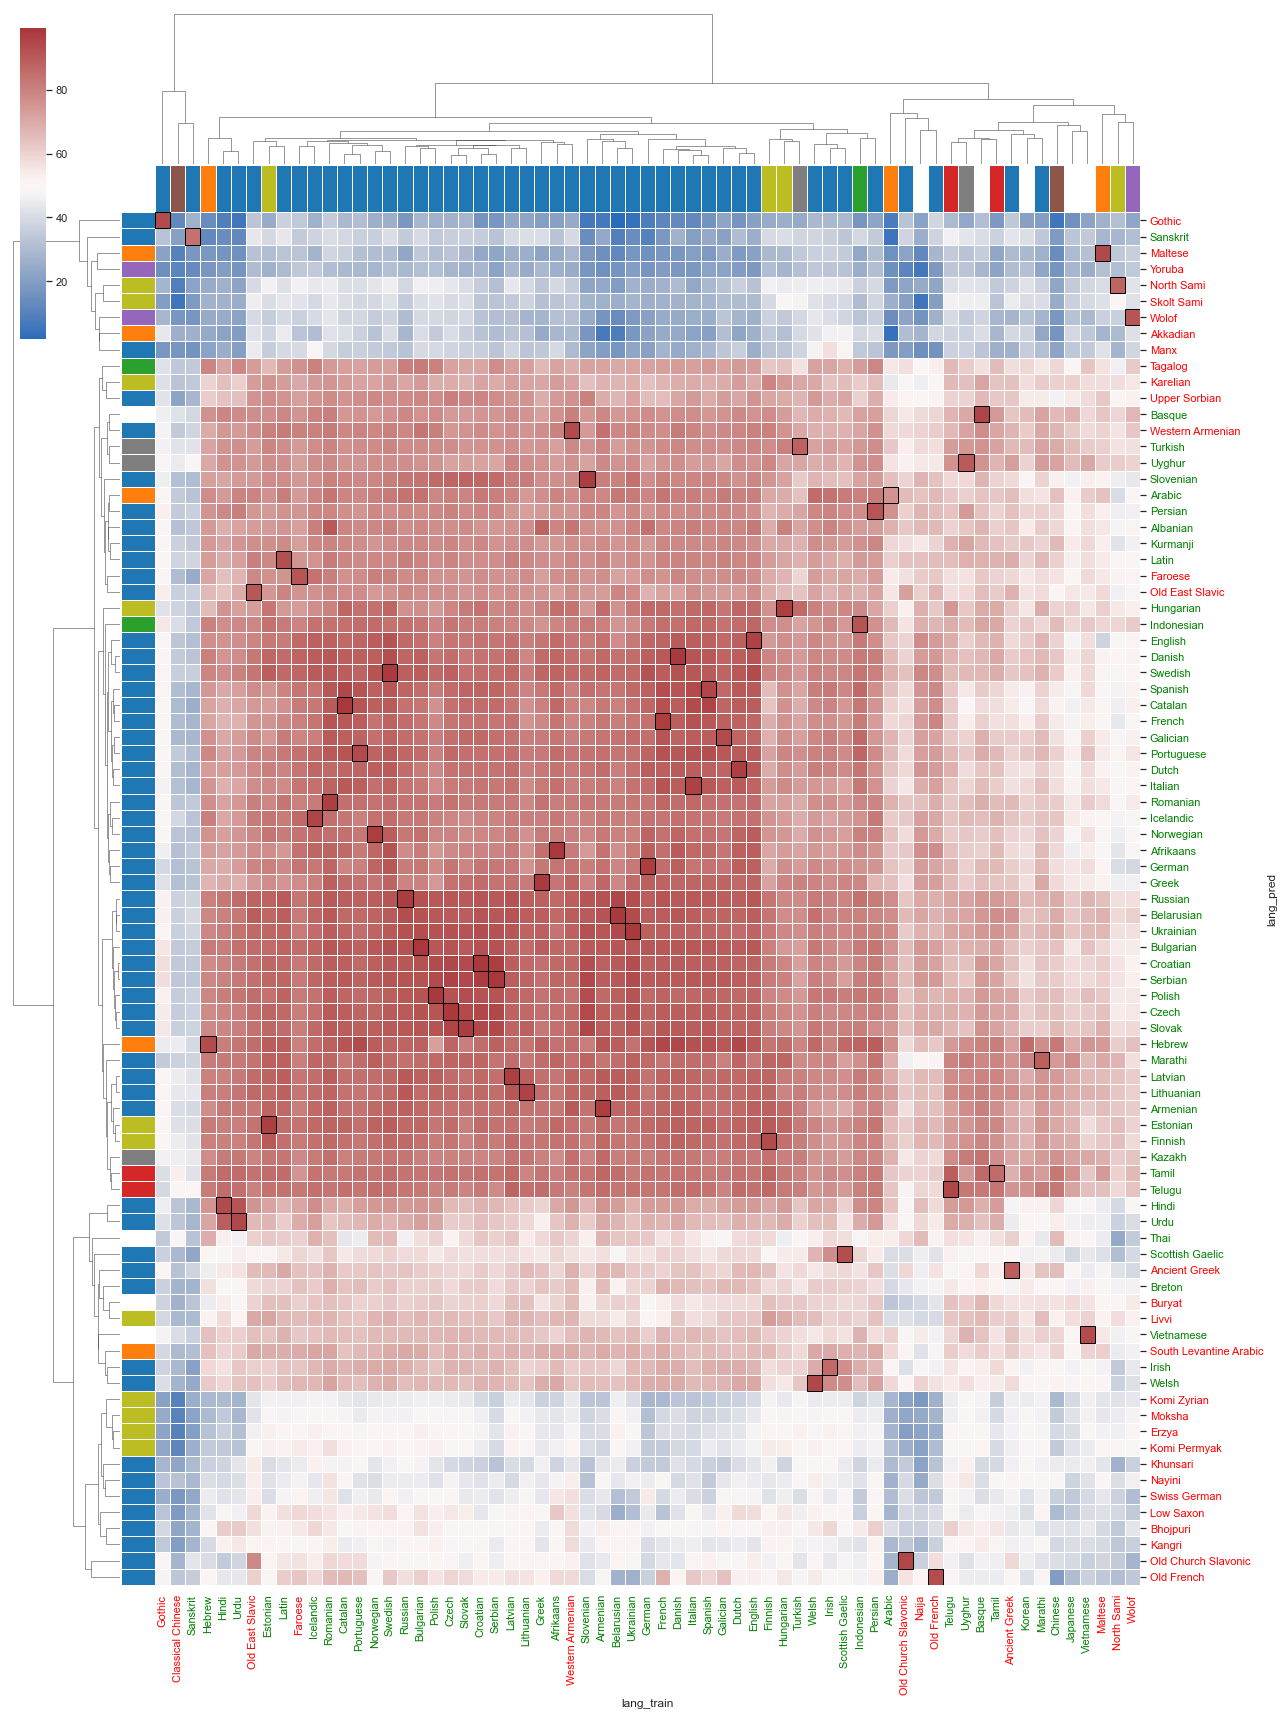

In [45]:
threshold = 80

# old turkic and syriac languages are not included in xlm-roberta pre-training
# tupian language family is not included in xlm-roberta pre-training
# logographic: ["chinese", "kana", "hangul"]

pred_names = masked_table.index.to_series()
mask = pred_names.map(lambda lang: ud_langs_scripts[lang] in ["old turkic", "syriac"]) | \
    pred_names.map(lambda lang: lang_fams[lang] in ["Tupian", "Chukotko-Kamchatkan", "Mayan", "Mande", "Pama-Nyungan", "Creole", "Arawakan"])| \
    pred_names.map(lambda lang: ud_langs_scripts[lang] in ["chinese", "kana", "hangul"])

removed_table = table.loc[mask]
bad_kept_table = table.loc[(masked_table.max(axis=1) < threshold) & (~mask)]
better_removed_table = table.loc[(masked_table.max(axis=1) >= threshold) & mask]
kept_table = table.loc[~mask]

create_clustermap(removed_table, figsize=(18,12))
create_clustermap(bad_kept_table, figsize=(18,12))
# if better_removed_table.size > 100:
#     create_clustermap(better_removed_table, figsize=(18,12))
create_clustermap(kept_table, figsize=(18,24))
better_removed_table

<AxesSubplot:xlabel='lang_train', ylabel='lang_pred'>

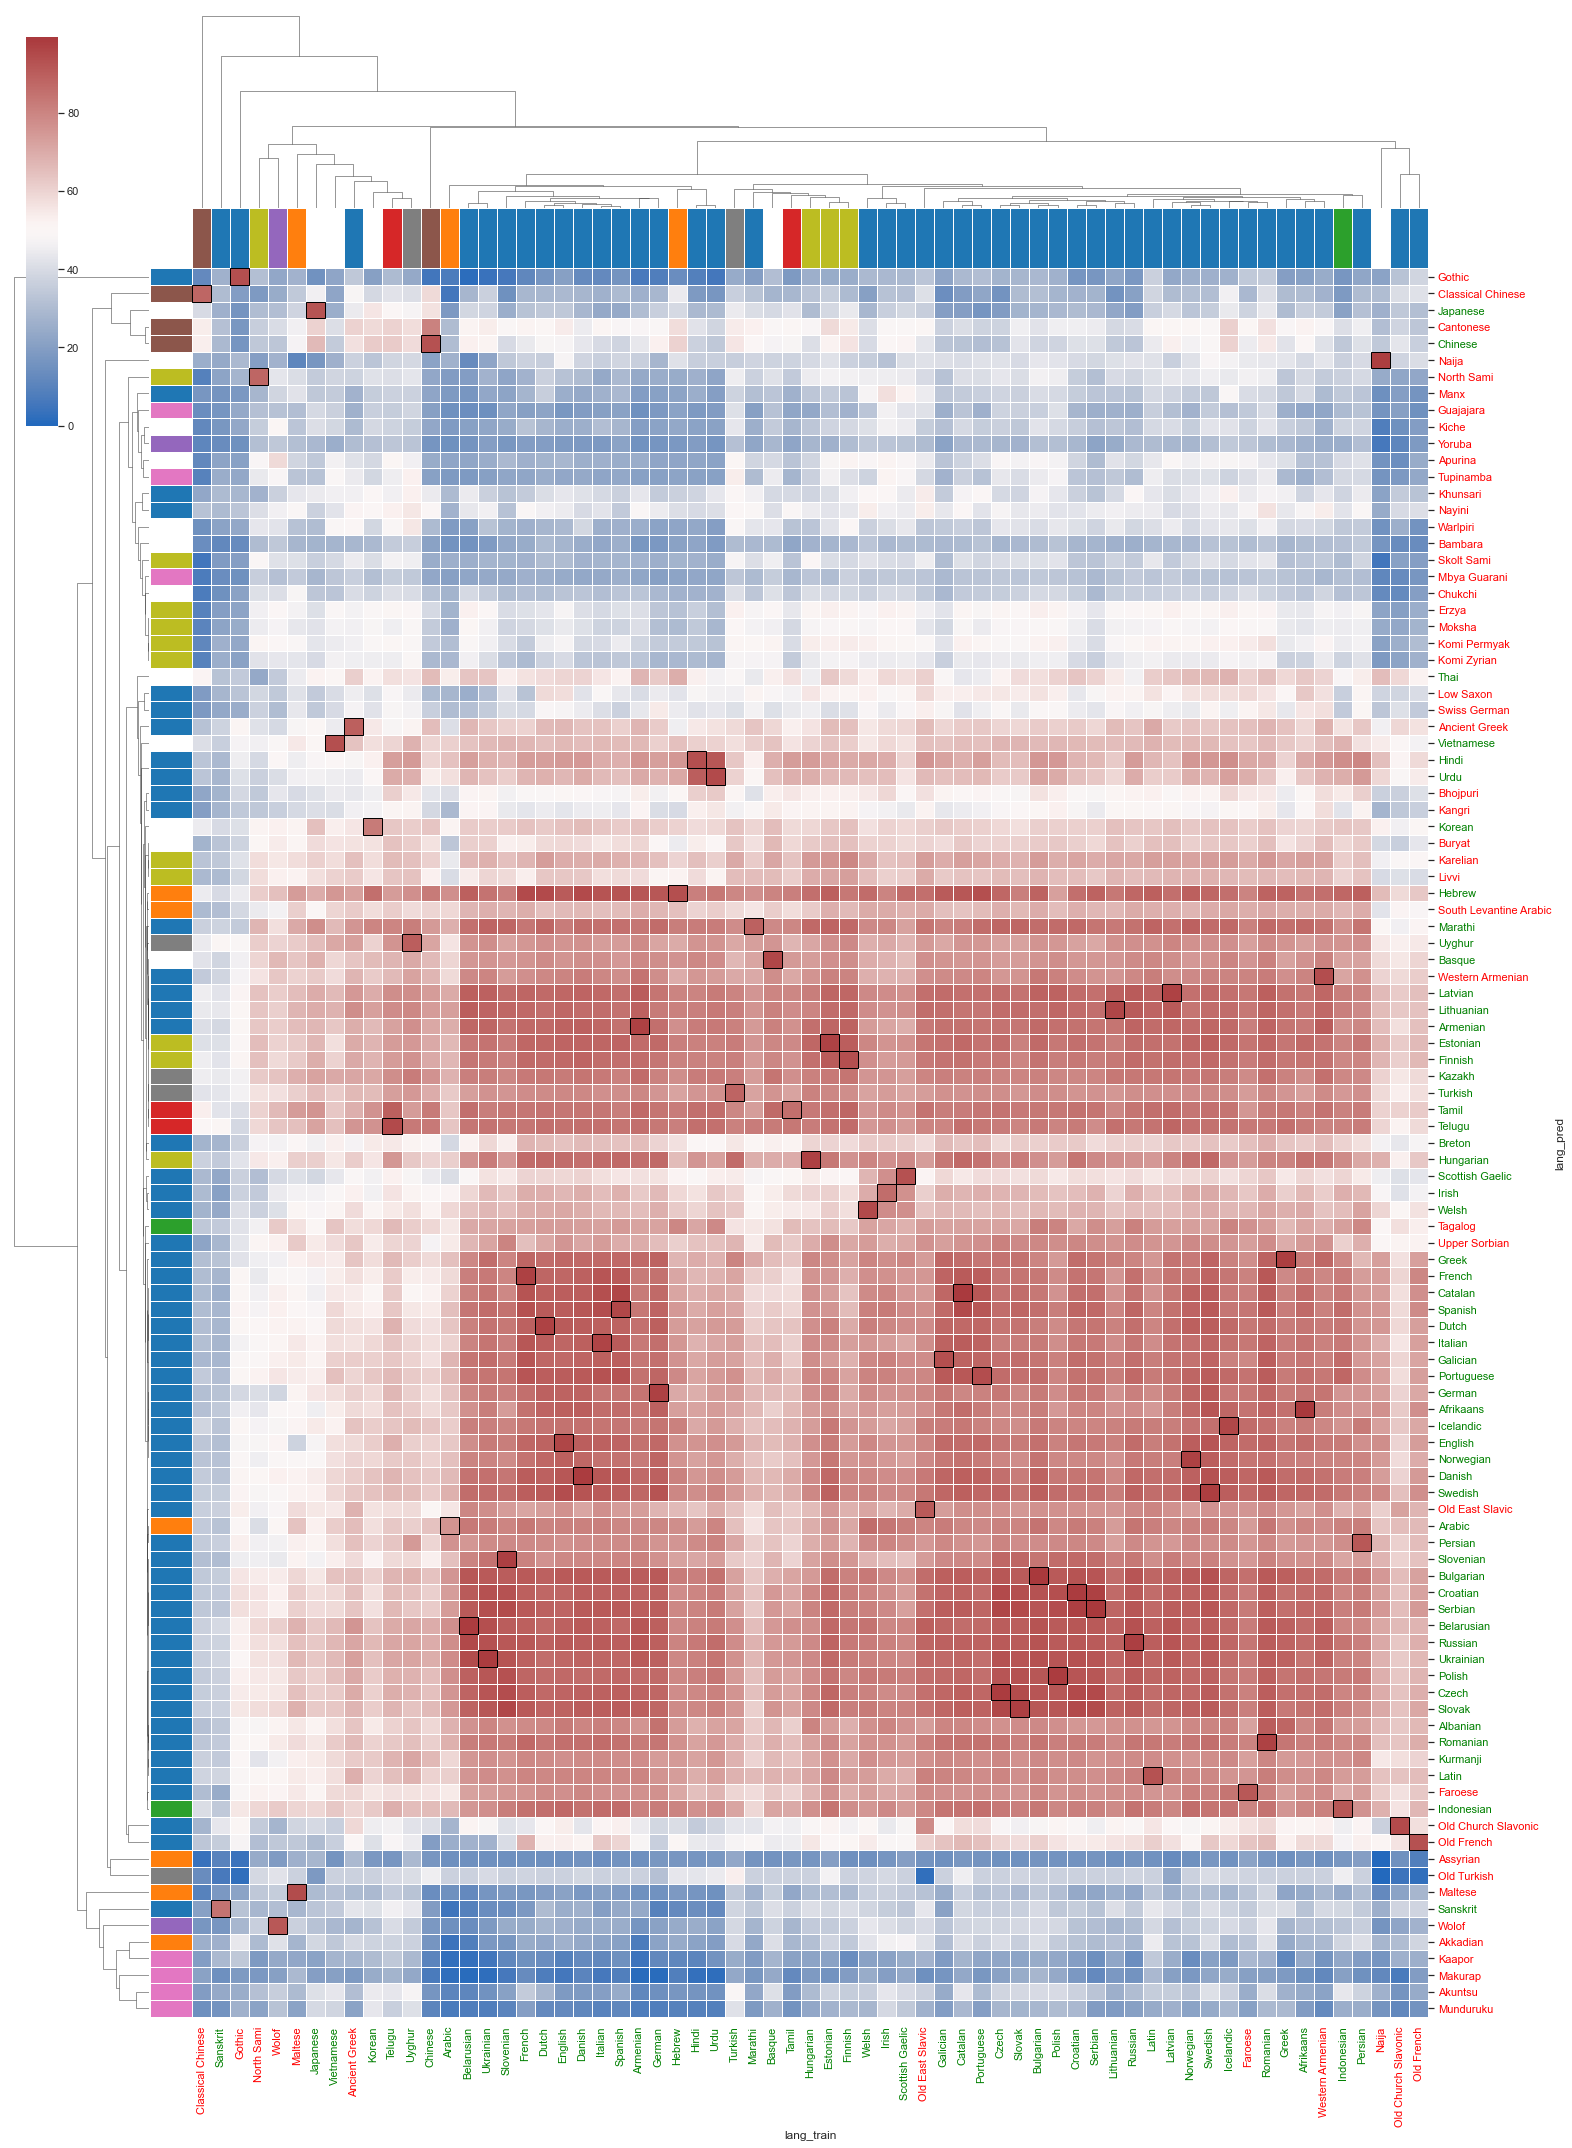

In [46]:

create_clustermap(table, figsize=(22, 30), metric="cosine")

In [47]:
print([n.upper().replace(" ", "_") for n in train_names])

['AFRIKAANS', 'ANCIENT_GREEK', 'ARABIC', 'ARMENIAN', 'BASQUE', 'BELARUSIAN', 'BULGARIAN', 'CATALAN', 'CHINESE', 'CLASSICAL_CHINESE', 'CROATIAN', 'CZECH', 'DANISH', 'DUTCH', 'ENGLISH', 'ESTONIAN', 'FAROESE', 'FINNISH', 'FRENCH', 'GALICIAN', 'GERMAN', 'GOTHIC', 'GREEK', 'HEBREW', 'HINDI', 'HUNGARIAN', 'ICELANDIC', 'INDONESIAN', 'IRISH', 'ITALIAN', 'JAPANESE', 'KOREAN', 'LATIN', 'LATVIAN', 'LITHUANIAN', 'MALTESE', 'MARATHI', 'NAIJA', 'NORTH_SAMI', 'NORWEGIAN', 'OLD_CHURCH_SLAVONIC', 'OLD_EAST_SLAVIC', 'OLD_FRENCH', 'PERSIAN', 'POLISH', 'PORTUGUESE', 'ROMANIAN', 'RUSSIAN', 'SANSKRIT', 'SCOTTISH_GAELIC', 'SERBIAN', 'SLOVAK', 'SLOVENIAN', 'SPANISH', 'SWEDISH', 'TAMIL', 'TELUGU', 'TURKISH', 'UKRAINIAN', 'URDU', 'UYGHUR', 'VIETNAMESE', 'WELSH', 'WESTERN_ARMENIAN', 'WOLOF']


In [48]:
# for n, score in table.iteritems():
#     if score[n] < 90:
#         print(n, score[n])

for n in ["Chinese", "Classical Chinese", "Japanese", "Korean", "Vietnamese"]:
    for n2, score in table[n].iteritems():
        if score > 80 and n2 not in ["Chinese", "Classical Chinese", "Japanese", "Korean", "Cantonese"]:
            print(n, n2, score)

Chinese Hebrew 82.29166666666666
Chinese Tamil 82.62383900928792
Chinese Telugu 82.80166435506241
Korean Hebrew 85.41666666666666
Vietnamese Vietnamese 93.66792137181096


In [49]:
pairs = []

for i, (tgt, row) in enumerate(masked_table.iterrows()):
    src = row.idxmax()
    pairs.append((src, tgt))

sources = set([s for s, _ in pairs])
print(len(sources), len(pairs))

for src, tgt in sorted(pairs):
    if lang_fams[tgt] != lang_fams[src]:
        print(f"{src:<20} {tgt:<20} {lang_fams[src]:<20} {lang_fams[tgt] if lang_fams[tgt] != lang_fams[src] else '':<20}")

44 105
Armenian             Kazakh               Indo-European        Turkic              
Basque               Buryat               Basque               Mongolic            
Belarusian           Moksha               Indo-European        Uralic              
Bulgarian            Erzya                Indo-European        Uralic              
Bulgarian            Tagalog              Indo-European        Austronesian        
Catalan              Hungarian            Indo-European        Uralic              
Chinese              Japanese             Sino-Tibetan         Japanese            
Danish               Hebrew               Indo-European        Afro-Asiatic        
Danish               Korean               Indo-European        Korean              
English              Indonesian           Indo-European        Austronesian        
Finnish              Mbya Guarani         Uralic               Tupian              
Hebrew               Thai                 Afro-Asiatic         Tai-Ka

## Performance varation for source and target languages

In [50]:
masked_table.mean(axis=0).std(), masked_table.mean(axis=1).std()

(7.870349316498049, 19.741218741982244)

## Source vs target language

In [ ]:
df_ = df.loc[df.lang_pred.isin(table.columns)]
table_ = df_.pivot(index='lang_pred', columns='lang_train', values='score')
df_

Text(1086.0, 0.5, 'Target language')

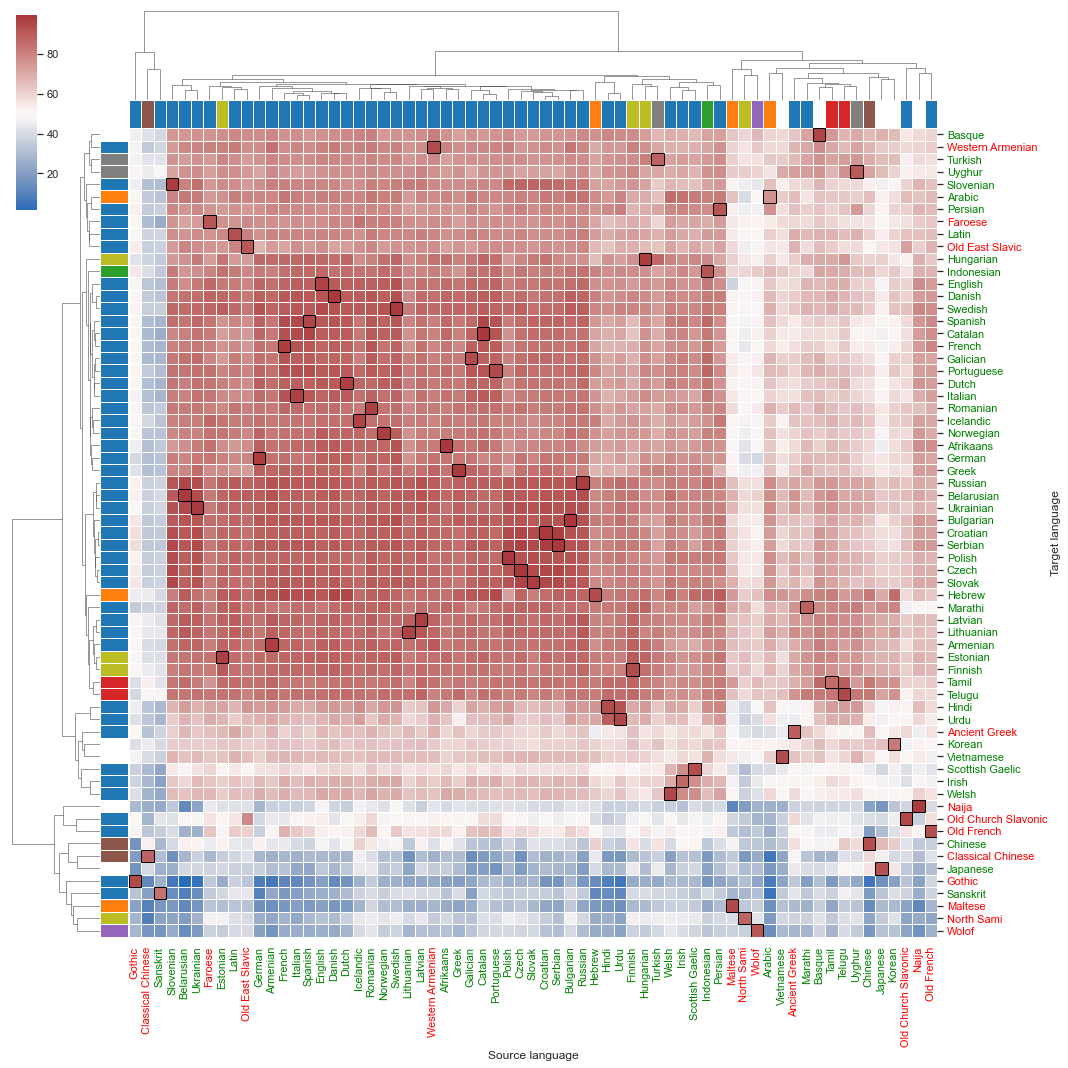

In [52]:
ax = create_clustermap(table_, figsize=(15, 15))
ax.set_xlabel("Source language")
ax.set_ylabel("Target language")

# os.makedirs("plots", exist_ok=True)
# plt.savefig("plots/heatmap-.pdf", bbox_inches="tight", transparent=True, pad_inches=0)

In [53]:
# import statsmodels.formula.api as smf
# from statsmodels.stats.anova import anova_lm

# # df_ = df.loc[df.lang_pred.isin(table.columns)]  # test in train
# # df_ = df.loc[df.lang_train_pretrained & df.lang_pred_pretrained]
# # df_ = df.loc[(~df.lang_train_pretrained) & (~df.lang_pred_pretrained)]
# df_ = df

# for q2 in ["", "+ lang_train_pretrained", "+ lang_pred_pretrained", "+ lang_train_pretrained + lang_pred_pretrained"]:
#     models = []
#     model_names = []
#     for q in ["lang_train_family", "lang_pred_family", "lang_train_family + lang_pred_family"]:
#         models.append(smf.ols(f"score ~ {q} {q2}", data=df_).fit())
#         model_names.append(f"{q} {q2}")

#     print(" ".join([f"{m.rsquared * 100:.1f}" for m in models]))

#     res = anova_lm(*models)
#     # res["predictors"] = model_names
#     print(res)
# # print(res.rsquared)

# # res.summary()

4.1 38.7 42.8
   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0    6812.0  3.341549e+06      0.0           NaN         NaN           NaN
1    6804.0  2.136575e+06      8.0  1.204974e+06  513.077990  0.000000e+00
2    6792.0  1.993894e+06     12.0  1.426811e+05   40.502402  5.958666e-93
5.7 41.4 44.4
   df_resid           ssr  df_diff       ss_diff           F        Pr(>F)
0    6811.0  3.285740e+06      0.0           NaN         NaN           NaN
1    6803.0  2.040979e+06      8.0  1.244761e+06  545.201541  0.000000e+00
2    6791.0  1.938085e+06     12.0  1.028937e+05   30.044749  6.607003e-68
48.5 57.3 61.4
   df_resid           ssr  df_diff        ss_diff           F         Pr(>F)
0    6811.0  1.794616e+06      0.0            NaN         NaN            NaN
1    6803.0  1.488565e+06      8.0  306050.993820  193.032211  2.631400e-295
2    6791.0  1.345884e+06     12.0  142681.078439   59.994455  8.009340e-139
50.1 60.0 63.0
   df_resid           ssr  df_diff

In [54]:
# df_ = df.loc[df.lang_train_pretrained & df.lang_pred_pretrained]
# # df_ = df.loc[(~df.lang_train_pretrained) & (~df.lang_pred_pretrained)]
# # df_ = df

# m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained", data=df_).fit()
# m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained", data=df_).fit()
# m2 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained + lang_pred_pretrained", data=df_).fit()
# # m3 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained * lang_pred_pretrained", data=df_).fit()
# models = [m0, m1, m2]

# print(" ".join([f"{m.rsquared * 100:.1f}" for m in models]))
# print(" ".join([f"{round(m.aic):,}" for m in models]))
# # m2.summary()

41.1 41.1 41.1
24,074 24,074 24,074


In [55]:
# df_ = df.loc[df.lang_train_pretrained & df.lang_pred_pretrained]
# # df_ = df.loc[(~df.lang_train_pretrained) & (~df.lang_pred_pretrained)]
# # df_ = df

# m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained + lang_pred_pretrained", data=df.loc[df.lang_train_pretrained & df.lang_pred_pretrained]).fit()
# m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained + lang_pred_pretrained", data=df.loc[df.lang_train_pretrained & ~df.lang_pred_pretrained]).fit()
# m2 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained + lang_pred_pretrained", data=df.loc[~df.lang_train_pretrained & df.lang_pred_pretrained]).fit()
# m3 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_train_pretrained + lang_pred_pretrained", data=df.loc[~df.lang_train_pretrained & ~df.lang_pred_pretrained]).fit()
# models = [m0, m1, m2, m3]

# print(" ".join([f"{m.rsquared * 100:.1f}" for m in models]))
# print(" ".join([f"{round(m.aic):,}" for m in models]))
# # m2.summary()

41.1 43.3 48.1 51.6
24,074 20,220 5,485 4,640


In [56]:
# m0 = smf.ols(f"score ~ lang_train_family", data=df).fit()
# m1 = smf.ols(f"score ~ lang_train + lang_pred", data=df).fit()
# models = [m0, m1]

# print(anova_lm(m0, m1))

# # m1.summary()

# # print(" ".join([f"{m.rsquared * 100:.1f}" for m in models]))
# # print(" ".join([f"{round(m.aic):,}" for m in models]))
# # m2.summary()

   df_resid           ssr  df_diff       ss_diff           F  Pr(>F)
0    6812.0  3.341549e+06      0.0           NaN         NaN     NaN
1    6656.0  4.352238e+05    156.0  2.906325e+06  284.918235     0.0


## Best source

In [1]:
# masked_table.mean(0).sort_values()
# for x,y in masked_table.mean(0).sort_values().iteritems():
#     print(f"{x:<30} {y:.1f}    {lang_fams[x]}")

In [58]:
masked_table.idxmax(1).value_counts()

Romanian            10
Swedish              7
Uyghur               4
Finnish              4
French               4
Irish                4
Latin                4
Western Armenian     3
Urdu                 3
Chinese              3
Belarusian           3
Latvian              3
English              3
Turkish              3
Hungarian            2
Czech                2
Telugu               2
Old East Slavic      2
Armenian             2
Catalan              2
Danish               2
Slovak               2
Estonian             2
Spanish              2
Icelandic            2
Bulgarian            2
Croatian             2
Wolof                2
Welsh                2
Maltese              2
Scottish Gaelic      2
Italian              1
Hebrew               1
Ukrainian            1
Basque               1
Korean               1
Japanese             1
Norwegian            1
Afrikaans            1
Russian              1
Serbian              1
Faroese              1
Old French           1
Hindi      

In [59]:
# table = df.pivot(index='lang_pred', columns='lang_train', values='score')
# # train_langs = table.columns.tolist()
# # table.index = table.index.map(lambda x: x if x in table.columns else f"{x} 🛑")
# masked_table = table.mask(table.apply(lambda x: x.name == x.index))
# table

best_langs = []
diff = 0

for fam in sorted(set(lang_fams.values())):
    df_ = df.loc[df.lang_pred_family == fam]
    if len(df_) == 0:
        continue
    table_ = df_.pivot(index='lang_pred', columns='lang_train', values='score')
    masked_table_ = table_.mask(table_.apply(lambda x: x.name == x.index))
    best = masked_table_.mean(0).idxmax()
    print(fam, best, lang_fams[best])
    best_langs.append(best)
    if lang_fams[best] != fam:
        diff += 1

print(f"Different family: {diff}/{len(best_langs)}")
for n, l in sorted([(best_langs.count(l), l) for l in set(best_langs)]):
    print(n, l)

Afro-Asiatic Romanian Indo-European
Arawakan Wolof Niger-Congo
Austro-Asiatic Latin Indo-European
Austronesian Russian Indo-European
Basque Romanian Indo-European
Chukotko-Kamchatkan Maltese Afro-Asiatic
Creole Swedish Indo-European
Dravidian Telugu Dravidian
Indo-European Romanian Indo-European
Japanese Chinese Sino-Tibetan
Korean Danish Indo-European
Mande Uyghur Turkic
Mayan Wolof Niger-Congo
Mongolic Basque Basque
Niger-Congo Welsh Indo-European
Pama-Nyungan Uyghur Turkic
Sino-Tibetan Chinese Sino-Tibetan
Tai-Kadai Hebrew Afro-Asiatic
Tupian Turkish Turkic
Turkic Estonian Uralic
Uralic Romanian Indo-European
Different family: 18/21
1 Basque
1 Danish
1 Estonian
1 Hebrew
1 Latin
1 Maltese
1 Russian
1 Swedish
1 Telugu
1 Turkish
1 Welsh
2 Chinese
2 Uyghur
2 Wolof
4 Romanian


In [60]:
df_ = df.loc[~df.lang_pred_pretrained]
table_ = df_.pivot(index='lang_pred', columns='lang_train', values='score')
masked_table_ = table_.mask(table_.apply(lambda x: x.name == x.index))
masked_table_.mean(0).sort_values()

lang_train
Classical Chinese      19.841516
Sanskrit               24.474763
Naija                  26.554454
Arabic                 26.805156
Gothic                 29.089562
Old Church Slavonic    30.798266
Old French             32.531017
Chinese                34.386880
German                 34.841922
Urdu                   34.856647
Belarusian             35.408154
Hindi                  35.533449
Hebrew                 35.942710
Slovenian              36.320730
Armenian               36.618840
Ukrainian              37.169370
North Sami             37.874718
Italian                38.521824
French                 38.530641
Spanish                38.718246
Danish                 38.732851
Japanese               38.875956
Tamil                  38.984974
Maltese                40.288250
Marathi                40.412755
Wolof                  40.514644
Dutch                  40.639289
English                40.765892
Serbian                40.948309
Vietnamese             40.977893

In [61]:
table.index.tolist()

['Afrikaans',
 'Akkadian',
 'Akuntsu',
 'Albanian',
 'Ancient Greek',
 'Apurina',
 'Arabic',
 'Armenian',
 'Assyrian',
 'Bambara',
 'Basque',
 'Belarusian',
 'Bhojpuri',
 'Breton',
 'Bulgarian',
 'Buryat',
 'Cantonese',
 'Catalan',
 'Chinese',
 'Chukchi',
 'Classical Chinese',
 'Croatian',
 'Czech',
 'Danish',
 'Dutch',
 'English',
 'Erzya',
 'Estonian',
 'Faroese',
 'Finnish',
 'French',
 'Galician',
 'German',
 'Gothic',
 'Greek',
 'Guajajara',
 'Hebrew',
 'Hindi',
 'Hungarian',
 'Icelandic',
 'Indonesian',
 'Irish',
 'Italian',
 'Japanese',
 'Kaapor',
 'Kangri',
 'Karelian',
 'Kazakh',
 'Khunsari',
 'Kiche',
 'Komi Permyak',
 'Komi Zyrian',
 'Korean',
 'Kurmanji',
 'Latin',
 'Latvian',
 'Lithuanian',
 'Livvi',
 'Low Saxon',
 'Makurap',
 'Maltese',
 'Manx',
 'Marathi',
 'Mbya Guarani',
 'Moksha',
 'Munduruku',
 'Naija',
 'Nayini',
 'North Sami',
 'Norwegian',
 'Old Church Slavonic',
 'Old East Slavic',
 'Old French',
 'Old Turkish',
 'Persian',
 'Polish',
 'Portuguese',
 'Romanian',


## Stats

In [62]:
rows = []

# df["gn_order_train"] = df.lang_train.map(lambda x: order_df.GN.get(x))
# df["gn_order_pred"] = df.lang_pred.map(lambda x: order_df.GN.get(x))
# df["an_order_train"] = df.lang_train.map(lambda x: order_df.AN.get(x))
# df["an_order_pred"] = df.lang_pred.map(lambda x: order_df.AN.get(x))
# df["dn_order_train"] = df.lang_train.map(lambda x: order_df.DN.get(x))
# df["dn_order_pred"] = df.lang_pred.map(lambda x: order_df.DN.get(x))
# df["nn_order_train"] = df.lang_train.map(lambda x: order_df.NN.get(x))
# df["nn_order_pred"] = df.lang_pred.map(lambda x: order_df.NN.get(x))
# df["rn_order_train"] = df.lang_train.map(lambda x: order_df.RN.get(x))
# df["rn_order_pred"] = df.lang_pred.map(lambda x: order_df.RN.get(x))
# df["qp_order_train"] = df.lang_train.map(lambda x: order_df.QP.get(x))
# df["qp_order_pred"] = df.lang_pred.map(lambda x: order_df.QP.get(x))

predictors = [
        "lang_train_family",
        "lang_pred_family",
        "lang_train_pretrained",
        "lang_pred_pretrained",
        "ldnd",
        "lang_train_script",
        "lang_pred_script",
        "sampling",
        "train_size",
        "sov_order_train",
        "sov_order_pred",
        # "sv_order_train",
        # "sv_order_pred",
        # "ov_order_train",
        # "ov_order_pred",
        "adpnp_order_train",
        "adpnp_order_pred",
        "gn_order_train",
        "gn_order_pred",
        "an_order_train",
        "an_order_pred",
        "dn_order_train",
        "dn_order_pred",
        "nn_order_train",
        "nn_order_pred",
        "rn_order_train",
        "rn_order_pred",
        "qp_order_train",
        "qp_order_pred",
]
for predictor in predictors:
    m = smf.ols(f"score ~ {predictor}", data=df).fit()
    rows.append((m.aic, m.rsquared, predictor))

for a, r, p in sorted(rows):
    print(f"{p:<30} {r * 100:5.2f} {a:.1f}")


rn_order_pred                  14.36 43660.8
qp_order_pred                  13.12 43733.4
nn_order_pred                  11.59 43812.1
adpnp_order_pred                9.91 43907.0
dn_order_pred                   9.87 43908.7
an_order_pred                   7.01 44063.0
gn_order_pred                   6.82 44073.6
sov_order_pred                  4.78 44182.4
rn_order_train                  1.64 53064.7
qp_order_train                  1.37 53084.7
adpnp_order_train               1.03 53099.2
dn_order_train                  0.61 53124.0
sov_order_train                 0.58 53127.6
gn_order_train                  0.50 53130.9
nn_order_train                  0.09 53150.6
an_order_train                  0.01 53157.4
lang_pred_pretrained           44.40 57923.2
lang_pred_family               38.68 58629.5
ldnd                           11.37 60456.9
lang_pred_script               11.15 61148.5
lang_train_family               4.10 61665.8
lang_train_pretrained           2.74 61739.3
lang_train

In [63]:
predictors = [
        "lang_train_family",
        "lang_pred_family",
        "lang_train_pretrained",
        "lang_pred_pretrained",
        "ldnd",
        "lang_train_script",
        "lang_pred_script",
        "sampling",
        "full_train_size",
        "sov_order_train",
        "sov_order_pred",
        "sv_order_train",
        "sv_order_pred",
        "ov_order_train",
        "ov_order_pred",
        "adpnp_order_train",
        "adpnp_order_pred",
        "gn_order_train",
        "gn_order_pred",
        "an_order_train",
        "an_order_pred",
        "dn_order_train",
        "dn_order_pred",
        "nn_order_train",
        "nn_order_pred",
        "rn_order_train",
        "rn_order_pred",
        "qp_order_train",
        "qp_order_pred",
]

m0 = smf.ols(f"score ~ {' + '.join(predictors)}", data=df).fit()
print(m0.rsquared)

while True:
    new_predictors = []
    for i in range(len(predictors)):
        m = smf.ols(f"score ~ {' + '.join(predictors[:i] + predictors[i+1:])}", data=df).fit()
        p = anova_lm(m, m0)["Pr(>F)"][1]
        if p < 0.05:
            new_predictors.append(predictors[i])
        else:
            print(f"~{predictors[i]:<30} {p:.3f} {m.rsquared * 100:.1f} {m.aic:.1f}")
    if len(new_predictors) == len(predictors):
        break
    predictors = new_predictors
    print()

" + ".join(predictors)

0.8760275363178001
~lang_train_pretrained          0.824 87.6 28900.8
~sampling                       0.373 87.6 28901.5
~sv_order_train                 0.855 87.6 28900.8
~ov_order_pred                  0.164 87.6 28902.7
~adpnp_order_train              0.223 87.6 28902.2
~gn_order_train                 0.625 87.6 28898.5
~an_order_train                 0.811 87.6 28900.8
~nn_order_train                 0.566 87.6 28901.1

~full_train_size                0.363 87.6 28893.0
~nn_order_pred                  0.054 87.5 28900.0



'lang_train_family + lang_pred_family + lang_pred_pretrained + ldnd + lang_train_script + lang_pred_script + sov_order_train + sov_order_pred + sv_order_pred + ov_order_train + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred'

In [64]:
m_id = smf.ols("score ~ lang_pred * lang_train", data=df).fit()
# m_id.summary()
m_id.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family + lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train + sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train + sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train + sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train + qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train + rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train + dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train * dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train * dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_train * gn_order_pred + an_order_pred + dn_order_train * dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m0 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_pred + ov_order_train + ov_order_pred + adpnp_order_pred + gn_order_pred + an_order_pred + dn_order_train * dn_order_pred + nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
m1 = smf.ols(f"score ~ lang_train_family * lang_pred_family + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_train * sv_order_pred + ov_order_train * ov_order_pred + adpnp_order_train * adpnp_order_pred + gn_order_train * gn_order_pred + an_order_train * an_order_pred + dn_order_train * dn_order_pred + nn_order_train * nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
m1 = smf.ols(f"score ~ lang_train_family_same + lang_pred_pretrained + ldnd + lang_pred_script + sov_order_train * sov_order_pred + sv_order_train * sv_order_pred + ov_order_train * ov_order_pred + adpnp_order_train * adpnp_order_pred + gn_order_train * gn_order_pred + an_order_train * an_order_pred + dn_order_train * dn_order_pred + nn_order_train * nn_order_pred + rn_order_train * rn_order_pred + qp_order_train * qp_order_pred", data=df).fit()
anova_lm(m0, m1)["Pr(>F)"][1], m0.rsquared, m1.rsquared

In [ ]:
# m1.summary()

## Worst within-language performance

In [ ]:
self_best_mask = table.idxmax() == table.columns
table.loc[:,~self_best_mask].idxmax()

In [ ]:
self_df = df.loc[df.lang_train == df.lang_pred].set_index("lang_train").score
self_df.sort_values()

In [ ]:
masked_table.mean().sort_values()